# Projet Traitement et Données Large Échelle

Zoé MARQUIS & Charlotte KRUZIC

!! Attention : Notebook très long (près d'une heure d'exécution)

Cela s'explique par la nature du benchmark :

- Chaque opération (Create, Read, Update, Delete) est répétée 5 fois pour assurer la fiabilité des résultats.
- À chaque Update ou Delete (et même Select pour rester cohérent), il est nécessaire de drop la table et l’index, puis de les recréer.
- Nous avons testé sur différents volumes de données : faible, 8k, et 30k, pour observer les variations de performances.
- Nous avons évalué les performances avec 1, 2, et 5 réplicas.
- Enfin, les tests ont été réalisés avec et sans index.

## Exécution des scripts d'installation 

Nous avons initialement exploré la possibilité d'exécuter nos scripts sur Google Colab afin de faciliter l'exécution sans que vous ayez à configurer quoi que ce soit sur votre machine locale. Cependant, Colab présente certaines limitations, notamment l'incapacité de gérer plusieurs réplicas sets, car il ne permet de travailler qu'avec un seul environnement d'exécution.

Pour pouvoir simuler plusieurs réplicas sets dans notre projet, nous avons besoin de plusieurs nœuds, ce qui n'est pas possible sur Colab. Nous avons également essayé d'utiliser des solutions gratuites comme Datastax (ou une autre plateforme similaire), mais ces services ne permettaient pas de configurer correctement les réplicas sets, ce qui limitait la flexibilité nécessaire à notre projet.

En conséquence, nous avons opté pour une autre solution : créer des fichiers de configuration et utiliser un Jupyter Notebook. Cette approche permet de travailler de manière plus flexible tout en maintenant un contrôle total sur les paramètres des réplicas sets.

Une autre remarque importante : le projet a été testé avec Python 3.11, car Python 3.12 a introduit quelques incompatibilités qui ont causé des bugs. Il est donc recommandé d'utiliser Python 3.11 pour éviter ces problèmes.

TODO CHARLOTTE : mets le set up ubuntu en place 

    sudo apt ...

### Choix de la base de données : MySQL vs SQLite
Initialement, nous avons choisi MySQL pour ses fonctionnalités robustes et sa capacité à gérer de grandes bases de données. Cependant, son intégration à Google Colab a posé plusieurs problèmes :

- Installation et configuration du serveur complexes dans un environnement éphémère.
- Difficulté à maintenir un serveur actif sur Colab, entraînant des arrêts inattendus.
- Configuration complexe pour établir des connexions sécurisées à distance. 

Pour simplifier, nous avons opté pour SQLite, une solution mieux adaptée à nos besoins :

- Sans serveur : Pas de configuration complexe, tout fonctionne directement via des fichiers.
- Compatibilité native : Intégré à Python, fonctionne localement et sur le cloud.

SQLite s'est révélé être une solution efficace, ce qui nous a incités à le conserver lors de notre transition vers Jupyter Notebook.

# Comparaison de Performances entre Systèmes Relationnels et NoSQL : Étude de Cas avec le Catalogue Netflix

Dans ce projet, nous comparons les performances entre un système de base de données relationnel (SQLite) et un système NoSQL (Cassandra), en utilisant le **catalogue Netflix** comme jeu de données.   
Ce dataset, disponible en Open Data, offre une structure réaliste et adaptée pour explorer les différences entre ces deux approches de gestion de données.   
L'objectif principal est d'évaluer les performances des opérations d'insertion, de sélection, de mise à jour et de suppression, tout en explorant les particularités du système NoSQL choisi.

### Jeu de données

Le jeu de données utilisé contient des informations sur les films et séries disponibles sur Netflix, avec les attributs suivants : 
- `show_id` : Identifiant unique pour chaque émission ou film. 
- `type` 
- `title`
- `director` 
- `cast`
- `country`
- `date_added` 
- `release_year` 
- `rating` 
- `duration` 
- `listed_in` 
- `description`

### Schéma de données

```sql
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
```


---

## Fonctionnement de Cassandra
Apache Cassandra est un système NoSQL conçu pour gérer de grandes quantités de données de manière distribuée, garantissant haute disponibilité et tolérance aux pannes grâce à son modèle décentralisé et évolutif.

### Modèle de données de Cassandra :

Le modèle de données de Cassandra repose sur quelques concepts clés qui diffèrent des systèmes relationnels traditionnels.

- **Keyspace** :  
Un Keyspace dans Cassandra est l'équivalent d'une base de données dans les systèmes relationnels. Il sert à regrouper des tables (ou Column Families) et définit la stratégie de réplication des données. Par exemple, il spécifie le nombre de répliques à conserver pour chaque donnée afin d'assurer une haute disponibilité et une tolérance aux pannes. La réplication des données dans Cassandra suit des stratégies comme "SimpleStrategy" (réplication sur tous les nœuds) ou "NetworkTopologyStrategy" (réplication sur des nœuds répartis sur plusieurs centres de données). Dans ce projet, nous n'explorerons que la stratégie "SimpleStrategy".
- **Column Family** :  
Une Column Family dans Cassandra est équivalente à une table relationnelle, mais avec une flexibilité plus grande. Chaque Column Family contient plusieurs colonnes, et contrairement aux bases de données relationnelles, les colonnes n'ont pas besoin d'être définies à l'avance. Elles peuvent être ajoutées dynamiquement au fil du temps, ce qui permet d'évoluer facilement sans migrations complexes.
- **Key (Clé primaire)** :  
Chaque ligne dans une Column Family est identifiée par une clé unique. Cette clé est utilisée pour partitionner et localiser les données efficacement. Elle peut être composée d'un seul champ (clé primaire simple) ou de plusieurs champs (clé primaire composée).
- **Colonnes** :  
Les données dans Cassandra sont stockées sous forme de colonnes. Chaque colonne a trois composants essentiels :
    - Nom : Le nom de la colonne (par exemple, title, release_year).
    - Valeur : La donnée proprement dite (par exemple, "Inception", "2010").
    - Timestamp : Le timestamp associé à la colonne, qui permet de gérer les versions des données et de résoudre les conflits de réplication, ce qui est essentiel dans un système distribué. Il permet de savoir quelle version d'une colonne est la plus récente.  
Ces colonnes sont indépendantes les unes des autres. Cela signifie qu'elles peuvent être insérées, mises à jour ou supprimées sans impacter les autres colonnes dans la même ligne.
- **Super Colonnes** :  
Les Super Colonnes sont une structure plus avancée dans Cassandra. Elles permettent de regrouper plusieurs colonnes sous un même nom de "super colonne". Cela permet de créer des structures hiérarchiques ou imbriquées dans les données, où une super colonne peut contenir plusieurs colonnes. Ce mécanisme est utile pour des cas complexes, mais il est souvent moins utilisé au profit de modèles de données plus simples.

Source : 
- http://www-igm.univ-mlv.fr/~dr/XPOSE2010/Cassandra/modele.html

### Les différentes clefs 

- **Clef primaire** :  Identifie de manière unique chaque enregistrement dans la table. Elle est formée de :
    - Clé de partition : Obligatoire.
    - Clés de clustering : Optionnelles.

- **Clef de partition** : Détermine sur quel nœud du cluster les données seront stockées. C'est la première composante de la clé primaire.
Cassandra utilise un algorithme de hachage pour distribuer les partitions uniformément sur les nœuds.
Tous les enregistrements ayant la même clé de partition seront stockés sur le même nœud (dans une partition).

- **Clef de clustering** : Organise les données au sein d'une partition.
Fait partie de la clé primaire, mais intervient après la clé de partition.
Les données sont triées dans l'ordre croissant (par défaut) ou décroissant au sein de chaque partition.

- **Clé secondaire** : Utilisée pour rechercher des données via une colonne qui n'est ni une clé de partition ni une clé de clustering. Cassandra génère un index secondaire pour accélérer les recherches sur cette colonne. Cependant, les performances peuvent être dégradées si l'index est utilisé pour des requêtes impliquant un balayage de nombreuses partitions. Une clé secondaire est définie en créant un **index** sur la colonne souhaitée.

Source: 
- https://www.baeldung.com/cassandra-keys

### Architecture de Cassandra :

L'architecture de Cassandra est décentralisée et repose sur un modèle peer-to-peer, ce qui signifie qu'il n'y a pas de nœud maître ou de coordination centralisée. Tous les nœuds sont égaux et partagent le même rôle. Cela permet une grande scalabilité et une tolérance aux pannes.

- **Partitions et Réplication** : Cassandra répartit les données entre différents nœuds via un mécanisme de partitionnement basé sur un hash de la clé primaire. Chaque nœud du cluster stocke une portion des données, et des répliques de ces données peuvent être présentes sur plusieurs nœuds, selon la stratégie de réplication définie dans le Keyspace. Cela permet à Cassandra d'assurer une haute disponibilité, même en cas de panne d'un ou plusieurs nœuds.
- **Consistence et Quorum** : Cassandra suit un modèle de consistance configurable, permettant de choisir entre des garanties de consistance fortes ou une consistance plus faible en fonction des besoins. Cela se configure via les paramètres Read Consistency Level et Write Consistency Level. Par exemple, un niveau de consistance QUORUM signifie qu'une opération de lecture ou d'écriture devra être validée par la majorité des répliques d'une donnée avant de réussir.

Source:
- https://www.geeksforgeeks.org/quorum-consistency-in-cassandra/

### Requêtes et Modèle de Consistance :

Les requêtes dans Cassandra utilisent le Cassandra Query Language (CQL), qui ressemble à SQL mais avec des différences significatives adaptées aux particularités du modèle NoSQL.

- **Clé primaire et partitions** : Dans Cassandra, la clé primaire détermine comment les données sont partitionnées et distribuées à travers les nœuds du cluster comme expliqué plus haut. Il est essentiel de bien concevoir cette clé pour assurer des performances optimales.
- **Sélection et filtrage** : Cassandra fonctionne très bien pour les requêtes basées sur la clé primaire. Les requêtes qui filtrent sur d'autres colonnes nécessitent l'utilisation d'index secondaires ou d'une modélisation spécifique des données pour garantir de bonnes performances. Filtrer sur une colonne sans index lève l'erreur ALLOW FILTERING, ce qui signifie que la requête pourrait être très coûteuse en termes de performance.

- 

### Avantages et Inconvénients de Cassandra :

#### Avantages :
- **Haute scalabilité horizontale** :
    - Possibilité d'ajouter facilement des nœuds pour s'adapter à une augmentation soudaine de la demande
    - Architecture scalable de façon linéaire permettant de déployer des clusters "multi-node"
- **Résilience et tolérance aux pannes**
    - Réplication des données sur plusieurs nœuds pour garantir une haute disponibilité
    Absence de point unique de défaillance
    - Capacité à continuer à fonctionner même en cas de panne d'un ou plusieurs nœuds
- **Flexibilité du modèle de données**
    - Prise en charge des données structurées, semi-structurées et non structurées
    - Possibilité d'ajouter de nouvelles colonnes sans affecter les données existantes
- **Performances élevées**
    - Impressionnante vitesse d'écriture de données
    - Capacité à traiter de vastes quantités de données dispersées entre de multiples serveurs
#### Inconvénients :
- L'un des principaux inconvénients de Cassandra réside dans la gestion des requêtes sur des colonnes non incluses dans la clé primaire, même lorsqu'un index est présent. Cela peut entraîner des problèmes de performances et nécessiter l'utilisation de la clause ALLOW FILTERING, qui est généralement déconseillée. 
Les index secondaires ne contiennent pas la clé de partition, ce qui oblige Cassandra à rechercher les données sur tous les nœuds du cluster. Cela peut être coûteux en termes de performances, surtout sur de grands clusters.
La clause ALLOW FILTERING est nécessaire lorsque Cassandra ne peut pas garantir une exécution efficace de la requête. Cela se produit souvent pour des requêtes impliquant des comparaisons (comme >, <) ou plusieurs colonnes filtrées sans clé de partition précise. 

Nous avions commencé à faire les comparaison de Select, Update et Delete avec release_year > 2000, mais cela oblige l'utilisation de ALLOW FILTERING, donc ne voyions aucune différence avec et sans index. Nous avons donc tout rejoué avec = 2000 pour pouvoir voir la différence.


Source : 
- https://www.lebigdata.fr/apache-cassandra-definition
- https://datascientest.com/apache-cassandra
- https://www.scnsoft.com/data/cassandra-performance


### Conclusion :
Cassandra est une base de données extrêmement puissante pour les cas d'utilisation à grande échelle et hautement distribués, avec une grande tolérance aux pannes. Cependant, sa conception impose certaines contraintes sur la manière de structurer les données, et une bonne compréhension de son modèle de partitionnement est essentielle pour garantir de bonnes performances. Si l'application nécessite des requêtes complexes ou des jointures, il est déconseillé d'utiliser Cassandra, car il n'est pas conçu pour ce type de traitement sans outils supplémentaires.

## Fonctionnement de SQLite
SQLite est une base de données relationnelle légère, autonome et sans serveur, idéale pour les applications qui nécessitent une gestion locale des données sans nécessiter de serveur de base de données externe. Voici les principaux points qui caractérisent son fonctionnement :

- Base de données embarquée : Contrairement aux systèmes de gestion de base de données classiques (comme MySQL ou PostgreSQL), SQLite est une base de données embarquée, ce qui signifie qu'elle est directement intégrée dans l'application sans nécessiter de processus serveur séparé. Toutes les données sont stockées dans un fichier unique sur le disque.
- Structure relationnelle : SQLite suit le modèle relationnel classique, avec des tables, des colonnes et des lignes. Il prend en charge les requêtes SQL classiques (SELECT, INSERT, UPDATE, DELETE), et permet la gestion des contraintes, des index et des transactions ACID (Atomicité, Cohérence, Isolation, Durabilité).
- Pas de gestion de serveur : SQLite ne nécessite pas d'installation de serveur ni de configuration complexe, ce qui simplifie grandement son utilisation pour des applications légères, des prototypes ou des applications mobiles. Cela permet également une gestion plus simple des données localement, sans besoin de se soucier de la gestion d'un serveur distant.
- Performance : Bien que très performant pour des opérations locales et des volumes de données modestes, SQLite n'est pas conçu pour les applications à grande échelle nécessitant une scalabilité horizontale ou une haute disponibilité. C'est une excellente solution pour des applications mononucléaires ou pour des projets qui ne nécessitent pas de réplication de données.
- Transactions ACID : SQLite assure l'intégrité des données grâce à son modèle transactionnel, ce qui garantit que les opérations sont atomiques et cohérentes. Cependant, sa gestion des transactions simultanées est moins robuste que dans des systèmes plus avancés comme PostgreSQL ou Cassandra.

### Avantages 

##### Efficacité en mémoire
SQLite se distingue par son faible besoin en mémoire. Avec seulement quelques centaines de kilooctets, la bibliothèque occupe un espace minimal, ce qui améliore naturellement la rapidité du système. Ce faible encombrement en fait une solution idéale pour des applications de toutes tailles, des plus simples aux plus complexes.

##### Autonomie
SQLite fonctionne sans nécessiter de logiciel serveur supplémentaire. Il s’intègre facilement, sans dépendances externes ou configurations complexes. Cela simplifie son utilisation tout en éliminant la charge de gestion d’un serveur.

##### Polyvalence
En plus de supporter la majorité des commandes SQL standard, SQLite est compatible avec de nombreux formats de données. Cette flexibilité a conduit à son adoption dans des applications majeures telles que Facebook et WhatsApp, ainsi que dans divers systèmes d’exploitation, navigateurs et outils professionnels. Sa capacité à permettre un échange fluide entre différents systèmes en fait un choix privilégié pour de nombreux développeurs.

##### Portabilité
Les fichiers SQLite sont faciles à sauvegarder et à transférer. Comme ils ne dépendent pas d’un serveur ou d’une configuration complexe, ils peuvent être utilisés sans problème sur des plateformes variées.

##### Fiabilité
Avec un accès aux données unifié, une faible consommation de ressources et une indépendance vis-à-vis de l’architecture serveur-client, SQLite est une option fiable. Les erreurs de mémoire ou les limitations dues à un manque de RAM y sont également moins fréquentes.

##### Libre de droits
SQLite est disponible en domaine public, sans licence. Seuls certains modules complémentaires et le support sont payants, ce qui en fait une solution économique.

### Limites de SQLite

##### Absence de gestion multi-utilisateurs
SQLite ne permet pas de gérer plusieurs comptes utilisateurs ou connexions simultanées. Contrairement à d’autres bases de données, il n’est pas conçu pour supporter une architecture multi-clients.

##### Impact de la croissance des données
Bien que léger, SQLite voit ses besoins en espace augmenter proportionnellement à la taille de la base de données. Cela peut avoir un effet négatif sur les performances lorsqu’il s’agit de gérer des volumes importants de données.

##### Limitation en flexibilité pour les requêtes client
En raison de son indépendance vis-à-vis des serveurs externes, SQLite ne prend pas en charge les requêtes de données effectuées directement par un client. De plus, il ne gère pas les connexions multiples simultanément, ce qui peut entraîner des retards dans certaines applications.

Source : https://www.ionos.fr/digitalguide/sites-internet/developpement-web/sqlite/#:~:text=En%20tant%20que%20système%20de,sont%20utilisées%20à%20cet%20effet.

---
## Installer les outils

In [1]:
!pip install plotly matplotlib pandas numpy cassandra_driver kagglehub tabulate

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# TODO à vérifier sur ubuntu et mac e fonctoin de comment on a fait les scripts d'installation
# # 🚨 sur linux 
# !apt-get update
# !apt-get install -y openjdk-11-jdk
# !apt-get install libev-dev
# !apt-get install cassandra

# # 🚨 sur mac
# !brew install openjdk@17
# !brew install libev
# !brew install cassandra


In [3]:
# importer toutes les librairies nécessaires
from cassandra.cluster import Cluster

import kagglehub

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import random

import sqlite3

from tabulate import tabulate
import time
import tracemalloc

/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importation des données

In [4]:
path = kagglehub.dataset_download("shivamb/netflix-shows")
print("Chemin vers le fichier du dataset : ", path)

Chemin vers le fichier du dataset :  /Users/zoemarquis/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5


In [5]:
files = os.listdir(path)
print("Nom du fichier : ", files)

Nom du fichier :  ['netflix_titles.csv']


In [6]:
filename = f"{path}/{files[0]}"
df_initial = pd.read_csv(filename)

In [7]:
print(tabulate(df_initial.head(10), headers='keys', tablefmt='psql'))

+----+-----------+---------+----------------------------------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+--------------------+----------------+----------+------------+---------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | show_id   | type    | title                            | director                      | cast                                                                                                                                                

In [8]:
# afficher le nombre de lignes dans le dataset
print(f"Nombre de lignes : {len(df_initial)}")

Nombre de lignes : 8807


In [9]:
# types des colonnes
print(df_initial.dtypes)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [43]:
# Convertir la colonne show_id en int en enlevant le préfixe 's' (plus simple pour gérer exactement le meme type de données en Cassandra et SQLite)
df_initial['show_id'] = df_initial['show_id'].str.replace('s', '').astype(int).astype(int)

df_initial['show_id'] = df_initial['show_id'].astype(int)
df_initial['release_year'] = df_initial['release_year'].astype(int)

df_initial['type'] = df_initial['title'].astype(str)
df_initial['title'] = df_initial['title'].astype(str)
df_initial['director'] = df_initial['director'].astype(str)
df_initial['cast'] = df_initial['cast'].astype(str)
df_initial['country'] = df_initial['country'].astype(str)
df_initial['date_added'] = df_initial['date_added'].astype(str)
df_initial['rating'] = df_initial['rating'].astype(str)
df_initial['duration'] = df_initial['duration'].astype(str)
df_initial['listed_in'] = df_initial['listed_in'].astype(str)
df_initial['description'] = df_initial['description'].astype(str)

AttributeError: Can only use .str accessor with string values!

In [11]:
# types des colonnes
print(df_initial.dtypes)

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


## CRUD : Create, Read, Update, Delete
- Create (*Insert*) : Insérer des données dans la base de données.
- Read (*Select*) : Récupérer des données.
- Update (*Update*) : Modifier des données existantes.
- Delete (*Delete*) : Effacer des données.

In [35]:
schema = """
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
"""

In [36]:
data_zoe_charlotte = {
    'show_id': [0],
    'title': ['Zoé & Charlotte'],
    'type': ['Movie'],
    'director': ['Christopher Nolan'],
    'cast': ['Leonardo DiCaprio, Joseph Gordon-Levitt'],
    'country': ['USA'],
    'date_added': ['2021-01-01'],
    'release_year': [2000],
    'rating': ['PG-13'],
    'duration': ['148 min'],
    'listed_in': ['Action, Sci-Fi'],
    'description': ['A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a CEO.']
}
df_zoe_charlotte = pd.DataFrame(data_zoe_charlotte)

### SQLite

In [37]:
# Créer une base de données SQLite en mémoire
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

def drop_table_sqlite():
    cursor.execute("DROP TABLE IF EXISTS shows;")
    conn.commit()

def create_table_sqlite():
    # Crée ta table ici
    cursor.execute(schema)
    conn.commit()

drop_table_sqlite()
create_table_sqlite()


In [38]:
# --- CREATE ---
def sqlite_insert(df):
    drop_table_sqlite()
    create_table_sqlite()
    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return create_time_sqlite, current, peak

# --- READ ---
def sqlite_read(df):
    sqlite_insert(df)

    tracemalloc.start()
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year = 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time_sqlite, current, peak

# --- UPDATE ---
def sqlite_update(df):
    sqlite_insert(df)

    tracemalloc.start() 
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year = 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time_sqlite, current, peak

# --- DELETE ---
def sqlite_delete(df):
    sqlite_insert(df)

    tracemalloc.start()
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year = 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time_sqlite, current, peak

In [ ]:
# Fonction pour effectuer une opération plusieurs fois et calculer la moyenne et l'écart-type
def benchmark_operation(func, *args):
    times = []
    current_memory = []
    peak_memory = []
    for _ in range(5):  # Effectuer 5 itérations
        temps, current, peak = func(*args)  # Exécuter la fonction avec les arguments
        times.append(temps)
        current_memory.append(current)
        peak_memory.append(peak)
    
    # Calculer la moyenne et l'écart-type
    mean_time = np.mean(times)
    std_time = np.std(times)
    mean_current_memory = np.mean(current_memory)
    std_current_memory = np.std(current_memory)
    mean_peak_memory = np.mean(peak_memory)
    std_peak_memory = np.std(peak_memory)
    return mean_time, std_time, mean_current_memory, std_current_memory, mean_peak_memory, std_peak_memory

# --- CREATE ---
create_sqlite_mean_time, create_sqlite_std_time, \
    create_sqlite_mean_current_memory, create_sqlite_std_current_memory, \
        create_sqlite_mean_peak_memory, create_sqlite_std_peak_memory = benchmark_operation(sqlite_insert, df_zoe_charlotte)

# --- READ ---
read_sqlite_mean_time, read_sqlite_std_time, \
    read_sqlite_mean_current_memory, read_sqlite_std_current_memory, \
        read_sqlite_mean_peak_memory, read_sqlite_std_peak_memory = benchmark_operation(sqlite_read, df_zoe_charlotte)

# --- UPDATE ---
update_sqlite_mean_time, update_sqlite_std_time, \
    update_sqlite_mean_current_memory, update_sqlite_std_current_memory, \
        update_sqlite_mean_peak_memory, update_sqlite_std_peak_memory = benchmark_operation(sqlite_update, df_zoe_charlotte)

# --- DELETE ---
delete_sqlite_mean_time, delete_sqlite_std_time, \
    delete_sqlite_mean_current_memory, delete_sqlite_std_current_memory, \
        delete_sqlite_mean_peak_memory, delete_sqlite_std_peak_memory = benchmark_operation(sqlite_delete, df_zoe_charlotte)

Create Time: 0.000913 seconds
Current memory usage is 8.331657409667969Mo; Peak was 9.616029739379883Mo
Create Time: 0.000258 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000165 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000127 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000123 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Total rows in 'shows' table: 1
Create Time: 0.000134 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Read Time: 0.000027 seconds
Queried 1 records
Current memory usage is 0.0016841888427734375Mo; Peak was 0.0017299652099609375Mo
Create Time: 0.000125 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Read Time: 0.000020 seconds
Queried 1 records
Current memory usage is 0.00144

##### Test d'insertion avec une ligne de DataFrame
Nous avons d'abord testé l'insertion d'une seule ligne de données extraite d'un DataFrame dans notre base de données. Cette étape permet de vérifier que l'insertion fonctionne correctement sur un cas simple, avant de passer à l'insertion de l'ensemble du DataFrame.

À ce stade, l'insertion a été réalisée avec succès sur une ligne de données, ce qui nous permet d'assurer que la logique de base est correcte. Nous allons maintenant procéder à l'insertion du DataFrame complet pour tester la gestion de plusieurs lignes et évaluer les performances d'insertion à plus grande échelle.

In [ ]:
# --- CREATE ---
create_sqlite_massive_mean_time, create_sqlite_massive_std_time, \
    create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory,\
    create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory  = benchmark_operation(sqlite_insert, df_initial)

# --- READ ---
read_sqlite_massive_mean_time, read_sqlite_massive_std_time, \
    read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory,\
    read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_read, df_initial)

# --- UPDATE ---
update_sqlite_massive_mean_time, update_sqlite_massive_std_time, \
    update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory,\
    update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_update, df_initial)

# --- DELETE ---
delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time, \
    delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory,\
    delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_delete, df_initial)

Create Time: 0.373759 seconds
Current memory usage is 1.6782007217407227Mo; Peak was 1.680729866027832Mo
Create Time: 0.368546 seconds
Current memory usage is 1.271550178527832Mo; Peak was 1.4052963256835938Mo
Create Time: 0.369570 seconds
Current memory usage is 1.2718210220336914Mo; Peak was 1.4052963256835938Mo
Create Time: 0.372908 seconds
Current memory usage is 1.271550178527832Mo; Peak was 1.4052963256835938Mo
Create Time: 0.372876 seconds
Current memory usage is 1.271550178527832Mo; Peak was 1.4052963256835938Mo
Total rows in 'shows' table: 8807
Create Time: 0.373123 seconds
Current memory usage is 1.271550178527832Mo; Peak was 1.4052963256835938Mo
Read Time: 0.000714 seconds
Queried 37 records
Current memory usage is 0.04055595397949219Mo; Peak was 0.04055595397949219Mo
Create Time: 0.408353 seconds
Current memory usage is 1.271550178527832Mo; Peak was 1.4052963256835938Mo
Read Time: 0.000838 seconds
Queried 37 records
Current memory usage is 0.03601646423339844Mo; Peak was 0.

### Cassandra

In [40]:
# vérifier l'état actuel du noeud Cassandra
!nodetool status

Datacenter: datacenter1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address    Load     Tokens  Owns (effective)  Host ID                               Rack 
UN  127.0.0.1  1,7 MiB  16      100,0%            11c2e131-3642-40ab-a44b-5d5e95f42edb  rack1



In [41]:
# Connexion à Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()


def drop_table_cassandra():
    session.execute("""
        DROP TABLE IF EXISTS netflix.shows;
        """)
    session.execute("""
        DROP KEYSPACE IF EXISTS netflix;
        """)

def create_table_cassandra(replication_factor):
    session.execute(f"""
        CREATE KEYSPACE netflix
        WITH REPLICATION = {{
            'class': 'SimpleStrategy', 
            'replication_factor': {replication_factor}
        }};
        """)
    session.set_keyspace('netflix')
    session.execute(schema)
    print(f"replication factor = {replication_factor}")

     
drop_table_cassandra()
create_table_cassandra(1)

replication factor = 1


##### Test sans index
Pour l'instant, nous effectuons les tests sans index. Cette approche nous permettra d'évaluer les performances de base. Nous ajouterons ensuite des index pour comparer les résultats et analyser l'impact sur les performances des requêtes.

In [42]:
# --- CREATE ---
def cassandra_insert(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Create Time: {create_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")

    return create_time, current, peak

# --- READ ---
def cassandra_read(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    # On utilise ici ALLOW FILTERING car release_year ne fait pas partie de la clef primaire et n'est pas indexé
    result = session.execute("SELECT * FROM shows WHERE release_year = 2000 ALLOW FILTERING")
    read_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time:.6f} seconds")
    num_records = sum(1 for _ in result)  # Count rows using a generator expression
    print(f"Queried {num_records} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time, current, peak

# --- UPDATE ---
def cassandra_update(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)

    tracemalloc.start()
    # On doit faire select et update car realease_year ne fait pas partie de la clef primaire
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year = 2000 ALLOW FILTERING;" 
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]

    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)

    update_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update Time: {update_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time, current, peak

# --- DELETE ---
def cassandra_delete(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)
    
    # Comme pour update
    tracemalloc.start()
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year = 2000 ALLOW FILTERING;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]

    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)

    delete_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time, current, peak

In [25]:
# --- CREATE ---
create_cas_mean_time, create_cas_std_time, \
    create_cas_mean_current_memory, create_cas_std_current_memory, \
        create_cas_mean_peak_memory, create_cas_std_peak_memory  = benchmark_operation(cassandra_insert, df_zoe_charlotte, 1)

# --- READ ---
read_cas_mean_time, read_cas_std_time, read_cas_mean_current_memory, \
    read_cas_std_current_memory, read_cas_mean_peak_memory, \
        read_cas_std_peak_memory  = benchmark_operation(cassandra_read, df_zoe_charlotte, 1)

# --- UPDATE ---
update_cas_mean_time, update_cas_std_time, \
    update_cas_mean_current_memory, update_cas_std_current_memory, \
        update_cas_mean_peak_memory, update_cas_std_peak_memory  = benchmark_operation(cassandra_update, df_zoe_charlotte, 1)

# --- DELETE ---
delete_cas_mean_time, delete_cas_std_time,  \
    delete_cas_mean_current_memory, delete_cas_std_current_memory,  \
        delete_cas_mean_peak_memory, delete_cas_std_peak_memory  = benchmark_operation(cassandra_delete, df_zoe_charlotte, 1)

replication factor = 1
Create Time: 0.000906 seconds
Current memory usage is 12.611929893493652Mo; Peak was 15.488755226135254Mo
replication factor = 1
Create Time: 0.002602 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.001456 seconds
Current memory usage is 0.006969451904296875Mo; Peak was 0.011620521545410156Mo
replication factor = 1
Create Time: 0.001480 seconds
Current memory usage is 0.006649017333984375Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.001488 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
Total rows in 'shows' table: 1
replication factor = 1
Create Time: 0.001256 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
Read Time: 0.001942 seconds
Queried 1 records
Current memory usage is 0.011590003967285156Mo; Peak was 0.042786598205566406Mo
replication factor = 1
Create Time: 0.002220 seconds
Curre

In [26]:
# --- CREATE ---
create_cas_massive_mean_time, create_cas_massive_std_time, \
    create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory, \
        create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory = benchmark_operation(cassandra_insert, df_initial, 1)

# --- READ ---
read_cas_massive_mean_time, read_cas_massive_std_time, \
    read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory, \
        read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory = benchmark_operation(cassandra_read, df_initial, 1)

# --- UPDATE ---
update_cas_massive_mean_time, update_cas_massive_std_time, \
    update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory, \
        update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory = benchmark_operation(cassandra_update, df_initial, 1)

# --- DELETE ---
delete_cas_massive_mean_time, delete_cas_massive_std_time, \
    delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory, \
        delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory = benchmark_operation(cassandra_delete, df_initial, 1)

replication factor = 1
Create Time: 4.187322 seconds
Current memory usage is 1.5261735916137695Mo; Peak was 1.6611003875732422Mo
replication factor = 1
Create Time: 4.148055 seconds
Current memory usage is 1.5385351181030273Mo; Peak was 1.644454002380371Mo
replication factor = 1
Create Time: 4.132988 seconds
Current memory usage is 1.6048469543457031Mo; Peak was 1.638676643371582Mo
replication factor = 1
Create Time: 4.326927 seconds
Current memory usage is 1.6116971969604492Mo; Peak was 1.636723518371582Mo
replication factor = 1
Create Time: 4.817982 seconds
Current memory usage is 1.6519804000854492Mo; Peak was 1.6615467071533203Mo
replication factor = 1
Create Time: 4.184263 seconds
Current memory usage is 1.6233587265014648Mo; Peak was 1.6439847946166992Mo
Read Time: 0.010113 seconds
Queried 37 records
Current memory usage is 0.05304431915283203Mo; Peak was 0.11151123046875Mo
replication factor = 1
Create Time: 4.182956 seconds
Current memory usage is 1.6074657440185547Mo; Peak was

### Visualisation
Nous avons d'abord testé avec un seul replicaSet et sans index, en insérant une seule ligne de données pour simplifier les tests.

Ensuite, pour obtenir des statistiques plus réalistes, nous avons effectué des opérations CRUD sur un volume de données plus important, en utilisant les données de Kaggle précédemment chargées. 

Chaque action (insertion, lecture, mise à jour, suppression) a été réalisée cinq fois, et nous avons calculé la moyenne et l'écart-type pour chaque opération afin d'effectuer un benchmarking précis.

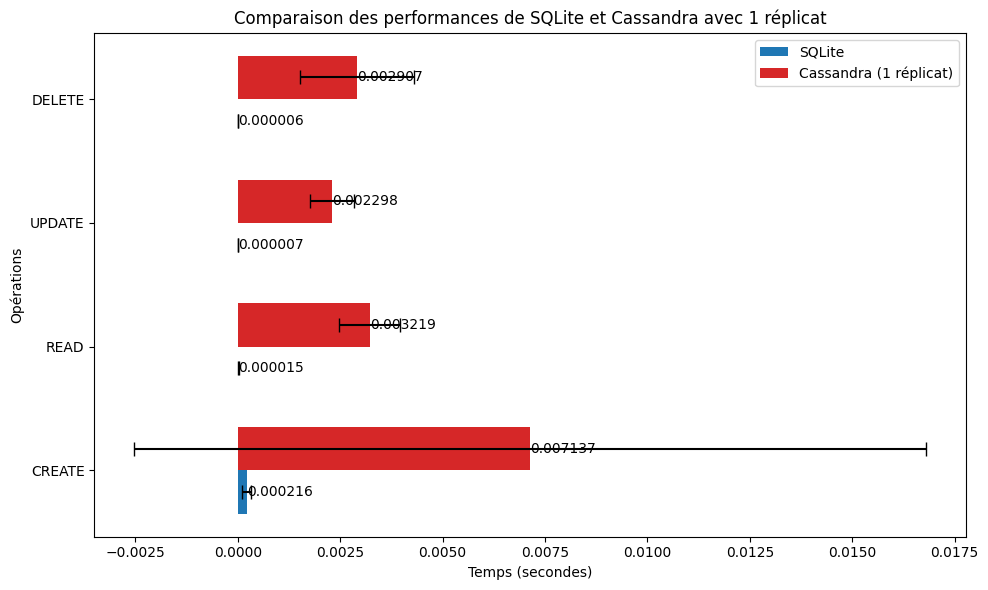

In [75]:
# Valeurs de temps pour SQLite
sqlite_times = {
    'CREATE': (create_sqlite_mean_time, create_sqlite_std_time),
    'READ': (read_sqlite_mean_time, read_sqlite_std_time),
    'UPDATE': (update_sqlite_mean_time, update_sqlite_std_time),
    'DELETE': (delete_sqlite_mean_time, delete_sqlite_std_time)
}

# Valeurs de temps pour Cassandra avec 1 réplicat
cassandra_times = {
    'CREATE': (create_cas_mean_time, create_cas_std_time),
    'READ': (read_cas_mean_time, read_cas_std_time),
    'UPDATE': (update_cas_mean_time, update_cas_std_time),
    'DELETE': (delete_cas_mean_time, delete_cas_std_time)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - height / 2, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5, color='tab:blue')
bars2 = ax.barh(y + height / 2, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5, color='tab:red')

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec 1 réplicat') 
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()


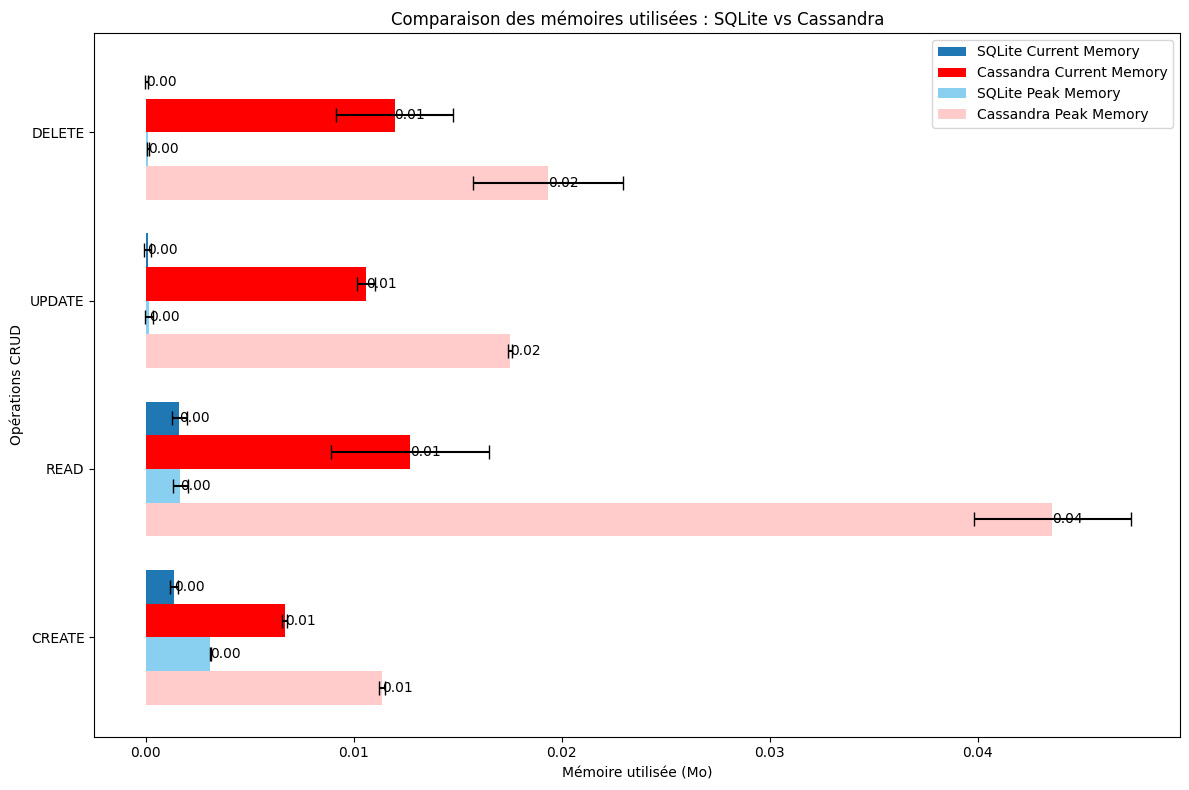

In [76]:
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_mean_current_memory, create_sqlite_std_current_memory),
               'peak': (create_sqlite_mean_peak_memory, create_sqlite_std_peak_memory)},
    'READ': {'current': (read_sqlite_mean_current_memory, read_sqlite_std_current_memory),
             'peak': (read_sqlite_mean_peak_memory, read_sqlite_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_mean_current_memory, update_sqlite_std_current_memory),
               'peak': (update_sqlite_mean_peak_memory, update_sqlite_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_mean_current_memory, delete_sqlite_std_current_memory),
               'peak': (delete_sqlite_mean_peak_memory, delete_sqlite_std_peak_memory)}
}

cassandra_memory = {
    'CREATE': {'current': (create_cas_mean_current_memory, create_cas_std_current_memory),
               'peak': (create_cas_mean_peak_memory, create_cas_std_peak_memory)},
    'READ': {'current': (read_cas_mean_current_memory, read_cas_std_current_memory),
             'peak': (read_cas_mean_peak_memory, read_cas_std_peak_memory)},
    'UPDATE': {'current': (update_cas_mean_current_memory, update_cas_std_current_memory),
               'peak': (update_cas_mean_peak_memory, update_cas_std_peak_memory)},
    'DELETE': {'current': (delete_cas_mean_current_memory, delete_cas_std_current_memory),
               'peak': (delete_cas_mean_peak_memory, delete_cas_std_peak_memory)}
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = [cassandra_memory[op]['current'][0] for op in operations]
cassandra_current_stds = [cassandra_memory[op]['current'][1] for op in operations]
cassandra_peak_means = [cassandra_memory[op]['peak'][0] for op in operations]
cassandra_peak_stds = [cassandra_memory[op]['peak'][1] for op in operations]

y = np.arange(len(operations))  
height = 0.2  

fig, ax = plt.subplots(figsize=(12, 8))

bars_sqlite_current = ax.barh(y + 1.5 * height, sqlite_current_means, height, 
                              xerr=sqlite_current_stds, label='SQLite Current Memory', color='tab:blue', capsize=5)
bars_cassandra_current = ax.barh(y + 0.5 * height, cassandra_current_means, height, 
                                  xerr=cassandra_current_stds, label='Cassandra Current Memory', color='red', capsize=5)
bars_sqlite_peak = ax.barh(y - 0.5 * height, sqlite_peak_means, height, 
                           xerr=sqlite_peak_stds, label='SQLite Peak Memory', color='#89CFF0', capsize=5) # bleu clair
bars_cassandra_peak = ax.barh(y - 1.5 * height, cassandra_peak_means, height, 
                               xerr=cassandra_peak_stds, label='Cassandra Peak Memory', color='#FFCCCB', capsize=5) # rouge clair

ax.set_xlabel('Mémoire utilisée (Mo)')
ax.set_ylabel('Opérations CRUD')
ax.set_title('Comparaison des mémoires utilisées : SQLite vs Cassandra')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

add_values(bars_sqlite_current)
add_values(bars_cassandra_current)
add_values(bars_sqlite_peak)
add_values(bars_cassandra_peak)

plt.tight_layout()
plt.show()


En testant SQLite et Cassandra avec une seule ligne de données et une réplication pour Cassandra, on remarque des différences claires :
 
- SQLite :  
Ici, l'opération la plus lente est la création de la ligne de données. En revanche, les lectures, mises à jour et suppressions sont rapides, ce qui montre que SQLite est bien optimisé pour des petits volumes de données.  
- Cassandra :  
La lecture est l'opération la plus rapide, ce qui correspond bien à la manière dont Cassandra est conçu pour gérer les requêtes en lecture.  
Les mises à jour et suppressions prennent à peu près le même temps, et sont un peu plus rapides que la création.  
La création, par contre, est la plus lente, probablement à cause de la gestion de la réplication et des contraintes liées à son architecture distribuée.    

Globalement, avec une seule ligne de données, Cassandra est beaucoup plus lent que SQLite. Cela s’explique par son architecture distribuée, qui ajoute un overhead même dans des contextes simples, et par ses mécanismes de réplication et de gestion des partitions, conçus pour des scénarios à grande échelle. En revanche, SQLite, étant une solution locale et légère, est optimisé pour des opérations rapides sur de petites bases de données.


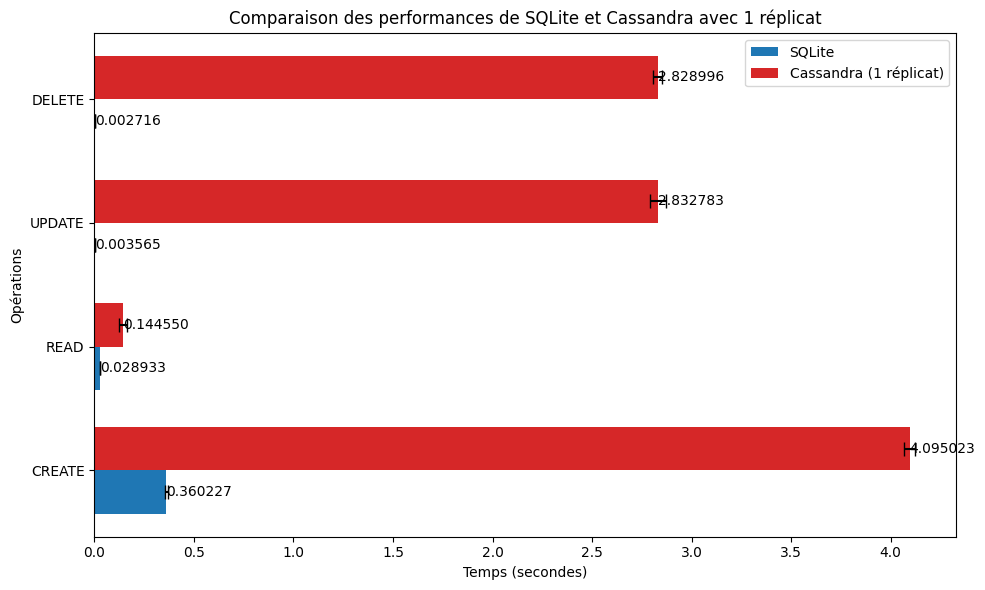

In [77]:
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean_time, create_sqlite_massive_std_time),
    'READ': (read_sqlite_massive_mean_time, read_sqlite_massive_std_time),
    'UPDATE': (update_sqlite_massive_mean_time, update_sqlite_massive_std_time),
    'DELETE': (delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time)
}

cassandra_times = {
    'CREATE': (create_cas_massive_mean_time, create_cas_massive_std_time),
    'READ': (read_cas_massive_mean_time, read_cas_massive_std_time),
    'UPDATE': (update_cas_massive_mean_time, update_cas_massive_std_time),
    'DELETE': (delete_cas_massive_mean_time, delete_cas_massive_std_time)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - height / 2, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5, color='tab:blue')
bars2 = ax.barh(y + height / 2, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5, color='tab:red')

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec 1 réplicat')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()

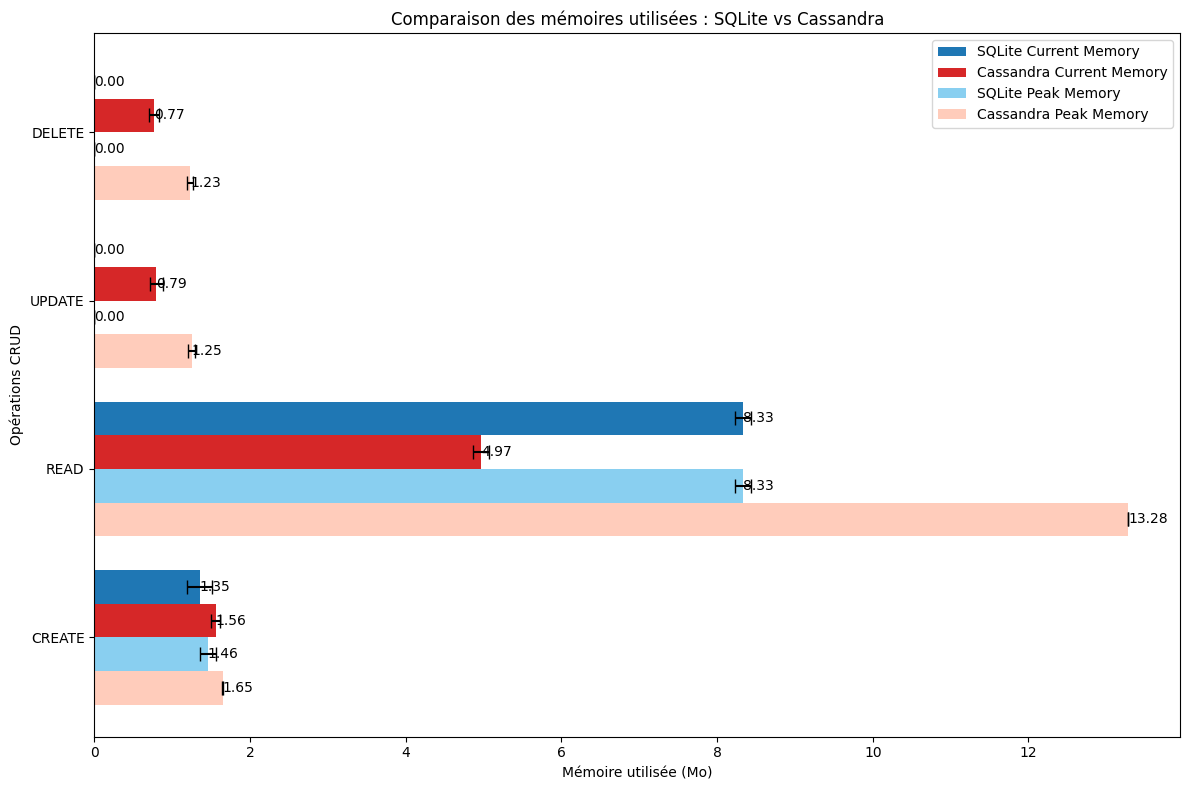

In [78]:
# Valeurs de mémoire pour SQLite (current et peak)
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory),
               'peak': (create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory)},
    'READ': {'current': (read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory),
             'peak': (read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory),
               'peak': (update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory),
               'peak': (delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra (current et peak)
cassandra_memory = {
    'CREATE': {'current': (create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory),
               'peak': (create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory)},
    'READ': {'current': (read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory),
             'peak': (read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory)},
    'UPDATE': {'current': (update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory),
               'peak': (update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory)},
    'DELETE': {'current': (delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory),
               'peak': (delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory)}
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = [cassandra_memory[op]['current'][0] for op in operations]
cassandra_current_stds = [cassandra_memory[op]['current'][1] for op in operations]
cassandra_peak_means = [cassandra_memory[op]['peak'][0] for op in operations]
cassandra_peak_stds = [cassandra_memory[op]['peak'][1] for op in operations]

y = np.arange(len(operations)) 
height = 0.2  

fig, ax = plt.subplots(figsize=(12, 8))

bars_sqlite_current = ax.barh(y + 1.5 * height, sqlite_current_means, height, 
                              xerr=sqlite_current_stds, label='SQLite Current Memory', color='tab:blue', capsize=5)
bars_cassandra_current = ax.barh(y + 0.5 * height, cassandra_current_means, height, 
                                  xerr=cassandra_current_stds, label='Cassandra Current Memory', color='tab:red', capsize=5)
bars_sqlite_peak = ax.barh(y - 0.5 * height, sqlite_peak_means, height, 
                           xerr=sqlite_peak_stds, label='SQLite Peak Memory', color='#89CFF0', capsize=5)
bars_cassandra_peak = ax.barh(y - 1.5 * height, cassandra_peak_means, height, 
                               xerr=cassandra_peak_stds, label='Cassandra Peak Memory', color='#FFCCBB', capsize=5)

ax.set_xlabel('Mémoire utilisée (Mo)')
ax.set_ylabel('Opérations CRUD')
ax.set_title('Comparaison des mémoires utilisées : SQLite vs Cassandra')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

add_values(bars_sqlite_current)
add_values(bars_cassandra_current)
add_values(bars_sqlite_peak)
add_values(bars_cassandra_peak)

plt.tight_layout()
plt.show()


Sur un volume de données beaucoup plus important, avec toujours un seul réplicat, la requête de création (CREATE) reste la plus longue pour SQLite comme pour Cassandra.

En Cassandra, les requêtes de lecture (READ) sont particulièrement rapides par rapport aux autres types de requêtes. Cela s'explique par la structure optimisée de Cassandra pour des lectures rapides, grâce à son indexation basée sur les partitions et l'utilisation de SSTables.

En revanche, les requêtes de suppression (DELETE) et de mise à jour (UPDATE) sont globalement plus longues et prennent un temps similaire en Cassandra, en raison des mécanismes internes de gestion des tombstones et de la propagation des modifications.

Enfin, même sur un grand volume de données, Cassandra reste globalement bien plus lent que SQLite, reflétant la différence entre une architecture distribuée conçue pour des données massives et une solution locale optimisée pour des bases de données plus légères.

Idées de pourquoi Cassandra reste plus lent : 
- Cassandra distribué : Optimisé pour des bases massives, mais sa gestion des partitions et des nœuds ajoute un coût, même sur une petite base.
- Replication : Même avec un seul réplicat, Cassandra gère la synchronisation, ce qui ralentit les écritures.
- Caching : SQLite utilise la mémoire locale efficacement, tandis que Cassandra coordonne entre nœuds, ce qui prend plus de temps.

## Comparaison des temps de Cassandra avec plusieurs replicaSet

##### Qu'est ce que *SimpleStrategy* ?
Description : Réplique les données de manière linéaire sur les n nœuds du cluster, où n est le replication_factor.
- Avantages :
    - Simple à configurer.
    - Adapté aux environnements de test ou aux clusters d'une seule région.
- Inconvénients :
    - Pas optimisé pour les déploiements multi-régions.
    - Répartition des réplicas pas toujours équilibrée en cas de cluster complexe.

In [79]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2, \
    create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2, \
        create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_insert, df_initial, 2)

# --- READ ---
read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2, \
    read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2, \
        read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_read, df_initial, 2)

# --- UPDATE ---
update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2, \
    update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2, \
        update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_update, df_initial, 2)

# --- DELETE ---
delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2, \
    delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2, \
        delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_delete, df_initial, 2)

replication factor = 2
Create Time: 4.101741 seconds
Current memory usage is 1.4948310852050781Mo; Peak was 1.660146713256836Mo
replication factor = 2
Create Time: 4.157813 seconds
Current memory usage is 1.469778060913086Mo; Peak was 1.6457300186157227Mo
replication factor = 2
Create Time: 4.118111 seconds
Current memory usage is 1.4706144332885742Mo; Peak was 1.6452655792236328Mo
replication factor = 2
Create Time: 4.136711 seconds
Current memory usage is 1.467726707458496Mo; Peak was 1.649688720703125Mo
replication factor = 2
Create Time: 4.140871 seconds
Current memory usage is 1.5076627731323242Mo; Peak was 1.641305923461914Mo
replication factor = 2
Create Time: 4.128819 seconds
Current memory usage is 1.49072265625Mo; Peak was 1.6434087753295898Mo
Read Time: 0.181944 seconds
Queried 8245 records
Current memory usage is 5.179039001464844Mo; Peak was 13.281332969665527Mo
replication factor = 2
Create Time: 4.107273 seconds
Current memory usage is 1.5704936981201172Mo; Peak was 1.67

In [81]:
# 5 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5, \
    create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5, \
        create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_insert, df_initial, 5)

# --- READ ---
read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5, \
    read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5, \
        read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_read, df_initial, 5)

# --- UPDATE ---
update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5, \
    update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5, \
        update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_update, df_initial, 5)

# --- DELETE ---
delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5, \
    delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5, \
        delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_delete, df_initial, 5)

replication factor = 5
Create Time: 4.443417 seconds
Current memory usage is 3.3054733276367188Mo; Peak was 3.489164352416992Mo
replication factor = 5
Create Time: 4.248832 seconds
Current memory usage is 1.6284914016723633Mo; Peak was 1.634718894958496Mo
replication factor = 5
Create Time: 4.309174 seconds
Current memory usage is 1.5009651184082031Mo; Peak was 1.6349725723266602Mo
replication factor = 5
Create Time: 4.146395 seconds
Current memory usage is 1.5458145141601562Mo; Peak was 1.647160530090332Mo
replication factor = 5
Create Time: 4.098009 seconds
Current memory usage is 1.555354118347168Mo; Peak was 1.652613639831543Mo
replication factor = 5
Create Time: 4.118371 seconds
Current memory usage is 1.5545597076416016Mo; Peak was 1.6463623046875Mo
Read Time: 0.136238 seconds
Queried 8245 records
Current memory usage is 5.176567077636719Mo; Peak was 13.281661033630371Mo
replication factor = 5
Create Time: 4.105634 seconds
Current memory usage is 1.4950199127197266Mo; Peak was 1.

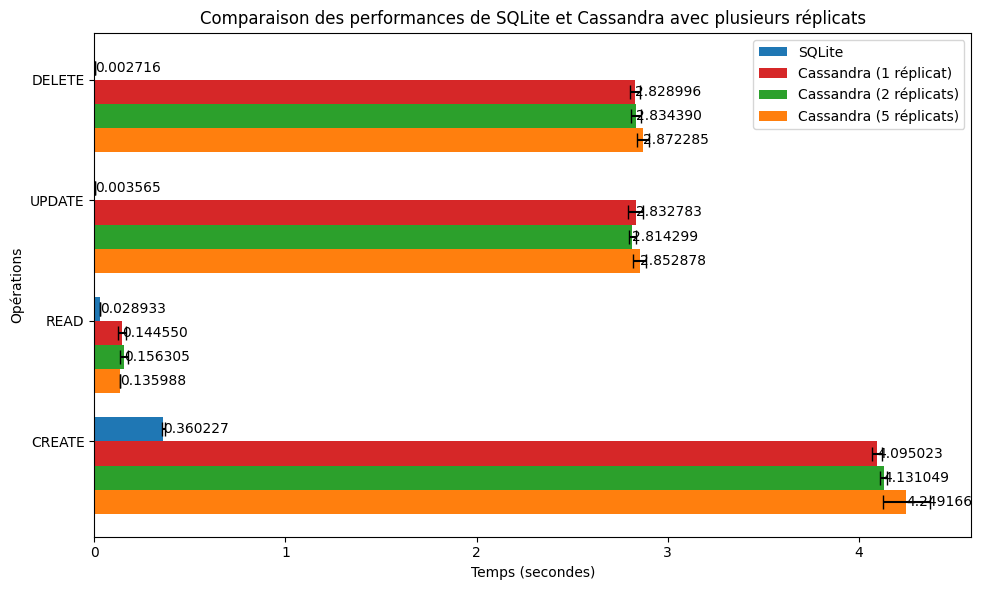

In [82]:
# Valeurs de temps pour SQLite
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean_time, create_sqlite_massive_std_time),
    'READ': (read_sqlite_massive_mean_time, read_sqlite_massive_std_time),
    'UPDATE': (update_sqlite_massive_mean_time, update_sqlite_massive_std_time),
    'DELETE': (delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time)
}

# Valeurs de temps pour Cassandra avec 1 réplicat
cassandra_times = {
    'CREATE': (create_cas_massive_mean_time, create_cas_massive_std_time),
    'READ': (read_cas_massive_mean_time, read_cas_massive_std_time),
    'UPDATE': (update_cas_massive_mean_time, update_cas_massive_std_time),
    'DELETE': (delete_cas_massive_mean_time, delete_cas_massive_std_time)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2),
    'READ': (read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2),
    'UPDATE': (update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2),
    'DELETE': (delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2)
}

cassandra_times_5 = {
    'CREATE': (create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5),
    'READ': (read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5),
    'UPDATE': (update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5),
    'DELETE': (delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5)
}


operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y + 0.5 * height, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5, color='tab:blue')
bars2 = ax.barh(y - 0.5 * height, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5, color='tab:red')
bars3 = ax.barh(y - 1.5 * height, cassandra_means_2, height, xerr=cassandra_stds_2, label='Cassandra (2 réplicats)', capsize=5, color='tab:green')
bars4 = ax.barh(y - 2.5 * height, cassandra_means_5, height, xerr=cassandra_stds_5, label='Cassandra (5 réplicats)', capsize=5, color='tab:orange')

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec plusieurs réplicats')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)

plt.tight_layout()
plt.show()

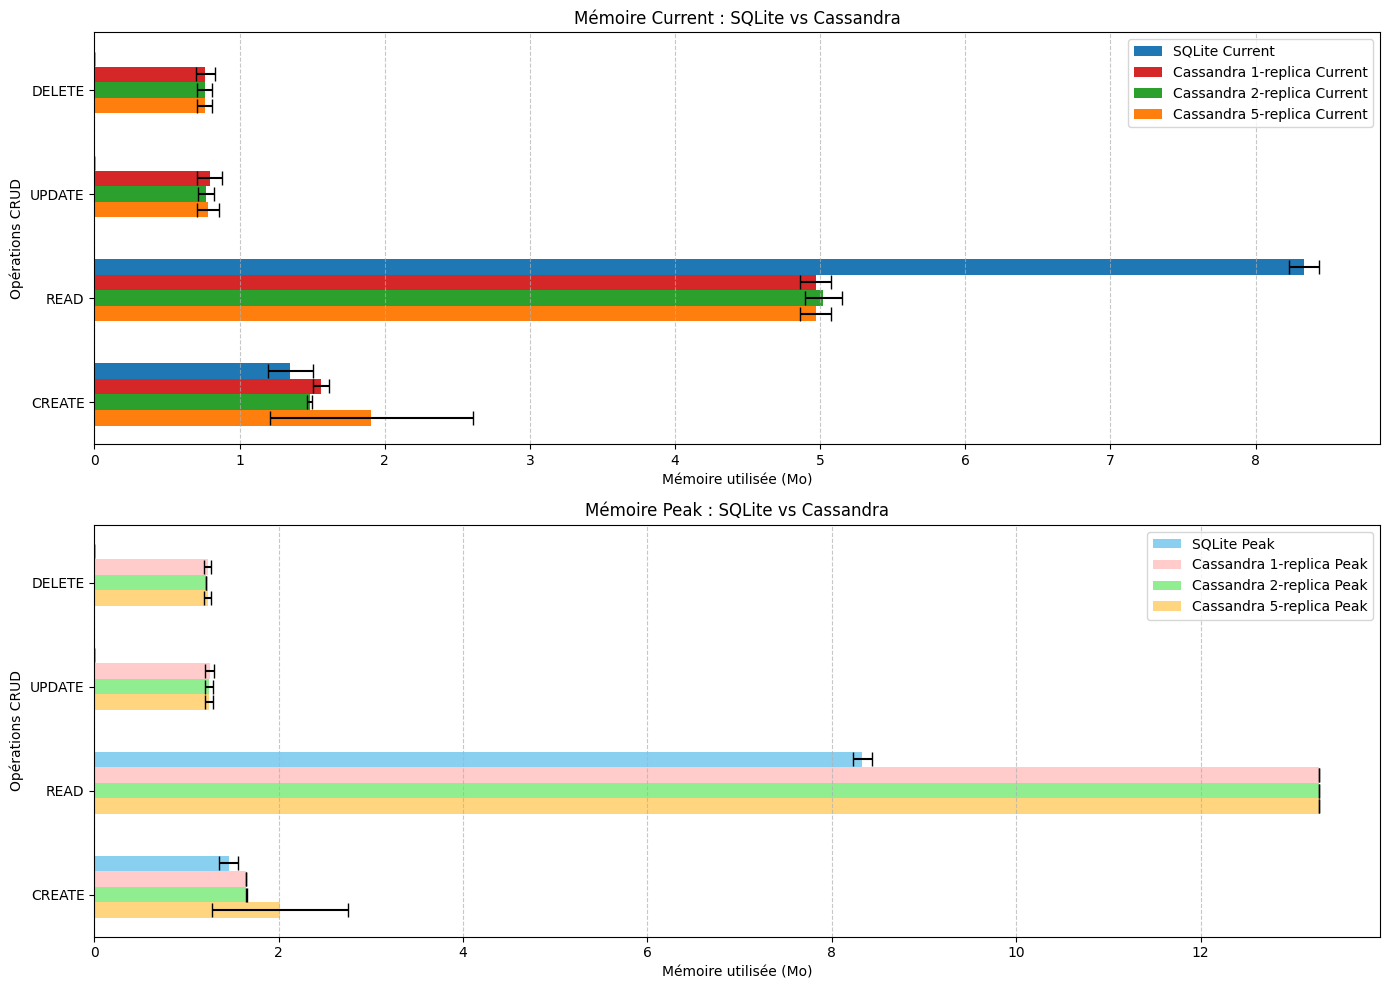

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Valeurs de mémoire pour SQLite
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory),
               'peak': (create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory)},
    'READ': {'current': (read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory),
             'peak': (read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory),
               'peak': (update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory),
               'peak': (delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra avec différentes réplications
cassandra_memory = {
    '1-replica': {
        'CREATE': {'current': (create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory),
                   'peak': (create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory)},
        'READ': {'current': (read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory),
                 'peak': (read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory)},
        'UPDATE': {'current': (update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory),
                   'peak': (update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory)},
        'DELETE': {'current': (delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory),
                   'peak': (delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory)}
    },
    '2-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2),
                   'peak': (create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2),
                 'peak': (read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2),
                   'peak': (update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2),
                   'peak': (delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2)}
    },
    '5-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5),
                   'peak': (create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5),
                 'peak': (read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5),
                   'peak': (update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5),
                   'peak': (delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5)}
    }
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Préparation des données
sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = {replica: [cassandra_memory[replica][op]['current'][0] for op in operations] for replica in cassandra_memory}
cassandra_current_stds = {replica: [cassandra_memory[replica][op]['current'][1] for op in operations] for replica in cassandra_memory}
cassandra_peak_means = {replica: [cassandra_memory[replica][op]['peak'][0] for op in operations] for replica in cassandra_memory}
cassandra_peak_stds = {replica: [cassandra_memory[replica][op]['peak'][1] for op in operations] for replica in cassandra_memory}

y = np.arange(len(operations))
height = 0.15

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

colors = ['tab:red', 'tab:green', 'tab:orange']
# Current Memory
ax[0].barh(y + 2 * height, sqlite_current_means, height, xerr=sqlite_current_stds, label='SQLite Current', color='tab:blue', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[0].barh(y + (1 - i) * height, cassandra_current_means[replica], height, xerr=cassandra_current_stds[replica], 
               label=f'Cassandra {replica} Current', capsize=5, color=colors[i])


colors = ['#FFCCCB', '#90EE90', '#FFD580']
# Peak Memory
ax[1].barh(y + 2 * height, sqlite_peak_means, height, xerr=sqlite_peak_stds, label='SQLite Peak', color='#89CFF0', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[1].barh(y + (1 - i) * height, cassandra_peak_means[replica], height, xerr=cassandra_peak_stds[replica], 
               label=f'Cassandra {replica} Peak', capsize=5, color=colors[i])

# Ajustements graphiques
for i in range(2):
    ax[i].set_xlabel('Mémoire utilisée (Mo)')
    ax[i].set_ylabel('Opérations CRUD')
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(operations)
    ax[i].legend()
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

ax[0].set_title('Mémoire Current : SQLite vs Cassandra')
ax[1].set_title('Mémoire Peak : SQLite vs Cassandra')

plt.tight_layout()
plt.show()


TODO commenter 

expliquer les temps : 

Pourquoi essayer plusieurs niveaux de réplication ?
Impact sur les performances des lectures : Plus vous avez de répliques, plus Cassandra doit examiner plusieurs nœuds pour répondre à une requête de lecture. Cela peut augmenter la latence en fonction du niveau de réplication et de la manière dont les nœuds sont répartis.
Impact sur les écritures : En fonction de la configuration de réplication, chaque écriture doit être propagée vers plusieurs nœuds. Cela peut augmenter le temps d'insertion ou d'update, surtout en cas de faible cohérence (si un niveau de cohérence faible est choisi).
Tolérance aux pannes : Un nombre plus élevé de répliques permet à Cassandra de maintenir la disponibilité même en cas de panne de certains nœuds. Cependant, cela peut aussi introduire des coûts en termes de latence et de consommation de ressources.

TODO on peut essayer par la suite pas avec 1 2 3 mais genre 1 5 10 ?

# Création d'un dataset plus grand

Utiliser une base de données plus grande : Cassandra est mieux adapté pour gérer de grandes quantités de données et pour tirer parti de son architecture distribuée.
On va donc augmenter notre jeu de données 

On crée nous même ce dataset car les sites de création de dataset ne permettent de télécharger que 1000 lignes avec un compte gratuit.

In [84]:
df_initial.shape

(8807, 12)

In [44]:
# Activer ou désactiver la génération de données supplémentaires
more_data = True

if more_data:
    # Charger le dataset initial
    original_df = df_initial  # Remplace par ton DataFrame de départ

    # Nombre total de lignes souhaitées
    num_rows = 30000

    # Fonction pour générer des colonnes supplémentaires à partir de données existantes
    def generate_large_column(original_column, size):
        return [random.choice(original_column) for _ in range(size)]

    # Fonction pour générer des IDs uniques
    def generate_unique_show_id(existing_ids, size):
        start_id = max(existing_ids) + 1 if existing_ids else 1
        return [f"{i}" for i in range(start_id, start_id + size)]

    # Générer les données pour chaque colonne
    generated_data = original_df.to_dict(orient='list')  # Convertir en dictionnaire de colonnes

    # Assurer l'unicité des IDs
    existing_ids = set(map(int, original_df["show_id"].tolist()))  # Obtenir les IDs existants
    new_ids = generate_unique_show_id(existing_ids, num_rows - len(original_df))
    generated_data["show_id"].extend(new_ids)

    # Générer les autres colonnes
    for column in original_df.columns:
        if column != "show_id":  # Ne pas regénérer la colonne show_id
            generated_data[column].extend(generate_large_column(original_df[column].tolist(), num_rows - len(original_df)))

    # Créer un DataFrame à partir des données générées
    large_df = pd.DataFrame(generated_data)

    # Supprimer les doublons éventuels (vérifie toutes les colonnes)
    large_df = large_df.drop_duplicates()

    # Remplacer les NaN explicitement pour chaque colonne
    for column in large_df.columns:
        if large_df[column].isnull().any():
            if large_df[column].dtype == "object":
                large_df[column].fillna("Unknown", inplace=True)  # Texte : remplacer par 'Unknown'
            else:
                large_df[column].fillna(0, inplace=True)  # Numérique : remplacer par 0

    # Supprimer les doublons éventuels (vérifie toutes les colonnes)
    large_df = large_df.drop_duplicates()

    # Vérifie qu'il n'y a pas de doublons dans 'show_id'
    if large_df["show_id"].duplicated().any():
        print("Attention : Des doublons existent dans la colonne 'show_id'.")
    else:
        print("Les IDs sont uniques.")

    # Sauvegarder le dataset dans un fichier CSV
    output_file = "netflix_titles_large.csv"
    large_df.to_csv(output_file, index=False)
    print(f"Dataset généré avec {len(large_df)} lignes (lignes dupliquées supprimées) et exporté dans {output_file}.")


Les IDs sont uniques.
Dataset généré avec 30000 lignes (lignes dupliquées supprimées) et exporté dans netflix_titles_large.csv.


In [86]:
large_df.shape

(30000, 12)

In [47]:
# Caster correctement les colonnes 
large_df['show_id'] = large_df['show_id'].astype(int)

large_df['show_id'] = large_df['show_id'].astype(int)
large_df['release_year'] = large_df['release_year'].astype(int)

large_df['type'] = large_df['title'].astype(str)
large_df['title'] = large_df['title'].astype(str)
large_df['director'] = large_df['director'].astype(str)
large_df['cast'] = large_df['cast'].astype(str)
large_df['country'] = large_df['country'].astype(str)
large_df['date_added'] = large_df['date_added'].astype(str)
large_df['rating'] = large_df['rating'].astype(str)
large_df['duration'] = large_df['duration'].astype(str)
large_df['listed_in'] = large_df['listed_in'].astype(str)
large_df['description'] = large_df['description'].astype(str)

In [88]:
# sqlite 
# --- CREATE ---
create_sqlite_massive_mean_time, create_sqlite_massive_std_time, \
    create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory, \
        create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_insert, large_df)

# --- READ ---
read_sqlite_massive_mean_time, read_sqlite_massive_std_time, \
    read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory, \
        read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_read, large_df)

# --- UPDATE ---
update_sqlite_massive_mean_time, update_sqlite_massive_std_time, \
    update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory, \
        update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_update, large_df)

# --- DELETE ---
delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time, \
    delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory, \
        delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_delete, large_df)

Create Time: 1.392178 seconds
Current memory usage is 4.346673965454102Mo; Peak was 4.803544044494629Mo
Create Time: 1.336178 seconds
Current memory usage is 4.343871116638184Mo; Peak was 4.80078125Mo
Create Time: 1.352741 seconds
Current memory usage is 4.34409236907959Mo; Peak was 4.80078125Mo
Create Time: 1.348297 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.298245 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Total rows in 'shows' table: 30000
Create Time: 1.350782 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.104535 seconds
Queried 28138 records
Current memory usage is 29.176372528076172Mo; Peak was 29.17656898498535Mo
Create Time: 1.303815 seconds
Current memory usage is 4.343573570251465Mo; Peak was 4.800727844238281Mo
Read Time: 0.101801 seconds
Queried 28138 records
Current memory usage is 28.915350914001465Mo; Peak was 28.915547370910645Mo
Create Time: 1.353014 

In [ ]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cas_mean_time, create_cas_std_time, \
    create_cas_mean_current_memory, create_cas_std_current_memory, \
        create_cas_mean_peak_memory, create_cas_std_peak_memory = benchmark_operation(cassandra_insert, large_df, 1)

# --- READ ---
read_cas_mean_time, read_cas_std_time, \
    read_cas_mean_current_memory, read_cas_std_current_memory, \
        read_cas_mean_peak_memory, read_cas_std_peak_memory = benchmark_operation(cassandra_read, large_df, 1)

# --- UPDATE ---
update_cas_mean_time, update_cas_std_time, \
    update_cas_mean_current_memory, update_cas_std_current_memory, \
        update_cas_mean_peak_memory, update_cas_std_peak_memory = benchmark_operation(cassandra_update, large_df, 1)

# --- DELETE ---
delete_cas_mean_time, delete_cas_std_time, \
    delete_cas_mean_current_memory, delete_cas_std_current_memory, \
        delete_cas_mean_peak_memory, delete_cas_std_peak_memory = benchmark_operation(cassandra_delete, large_df, 1)

replication factor = 1
Create Time: 13.976066 seconds
Current memory usage is 4.855355262756348Mo; Peak was 4.986985206604004Mo
replication factor = 1
Create Time: 13.936364 seconds
Current memory usage is 4.796787261962891Mo; Peak was 4.975197792053223Mo
replication factor = 1
Create Time: 13.952007 seconds
Current memory usage is 4.931833267211914Mo; Peak was 4.964864730834961Mo
replication factor = 1
Create Time: 13.959163 seconds
Current memory usage is 4.888238906860352Mo; Peak was 4.971634864807129Mo
replication factor = 1
Create Time: 13.881480 seconds
Current memory usage is 4.905740737915039Mo; Peak was 4.975409507751465Mo
Total rows in 'shows' table: 30000
replication factor = 1
Create Time: 13.949563 seconds
Current memory usage is 4.838356971740723Mo; Peak was 4.967281341552734Mo
Read Time: 0.137884 seconds
Queried 28138 records
Current memory usage is 4.9182891845703125Mo; Peak was 13.286503791809082Mo
replication factor = 1
Create Time: 13.997631 seconds
Current memory us

In [90]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2, \
    create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2, \
        create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_insert, large_df, 2)

# --- READ ---
read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2, \
    read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2, \
        read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_read, large_df, 2)

# --- UPDATE ---
update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2, \
    update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2, \
        update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_update, large_df, 2)

# --- DELETE ---
delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2, \
    delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2, \
        delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_delete, large_df, 2)


replication factor = 2
Create Time: 13.993764 seconds
Current memory usage is 4.89430046081543Mo; Peak was 4.958405494689941Mo
replication factor = 2
Create Time: 13.880514 seconds
Current memory usage is 4.862174987792969Mo; Peak was 4.97087287902832Mo
replication factor = 2
Create Time: 13.894292 seconds
Current memory usage is 4.809112548828125Mo; Peak was 4.970003128051758Mo
replication factor = 2
Create Time: 13.885428 seconds
Current memory usage is 4.937444686889648Mo; Peak was 4.966348648071289Mo
replication factor = 2
Create Time: 13.874090 seconds
Current memory usage is 4.897365570068359Mo; Peak was 4.966316223144531Mo
replication factor = 2
Create Time: 13.834033 seconds
Current memory usage is 4.8484296798706055Mo; Peak was 4.964134216308594Mo
Read Time: 0.140310 seconds
Queried 28138 records
Current memory usage is 5.177642822265625Mo; Peak was 13.28831958770752Mo
replication factor = 2
Create Time: 13.877682 seconds
Current memory usage is 4.836172103881836Mo; Peak was 4

In [91]:
# 5 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5, \
    create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5, \
        create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_insert, large_df, 5)

# --- READ ---
read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5, \
    read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5, \
        read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_read, large_df, 5)

# --- UPDATE ---
update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5, \
    update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5, \
        update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_update, large_df, 5)

# --- DELETE ---
delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5, \
    delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5, \
        delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_delete, large_df, 5)


replication factor = 5
Create Time: 14.181744 seconds
Current memory usage is 4.901741981506348Mo; Peak was 4.956622123718262Mo
replication factor = 5
Create Time: 14.173169 seconds
Current memory usage is 4.871842384338379Mo; Peak was 4.987451553344727Mo
replication factor = 5
Create Time: 13.834126 seconds
Current memory usage is 4.8884429931640625Mo; Peak was 4.9707746505737305Mo
replication factor = 5
Create Time: 13.864083 seconds
Current memory usage is 4.838802337646484Mo; Peak was 4.971094131469727Mo
replication factor = 5
Create Time: 13.874136 seconds
Current memory usage is 4.915859222412109Mo; Peak was 4.968415260314941Mo
replication factor = 5
Create Time: 13.970121 seconds
Current memory usage is 4.929874420166016Mo; Peak was 4.97994327545166Mo
Read Time: 0.140337 seconds
Queried 28138 records
Current memory usage is 5.178070068359375Mo; Peak was 13.28618335723877Mo
replication factor = 5
Create Time: 13.971516 seconds
Current memory usage is 4.824864387512207Mo; Peak was

## Visualisation

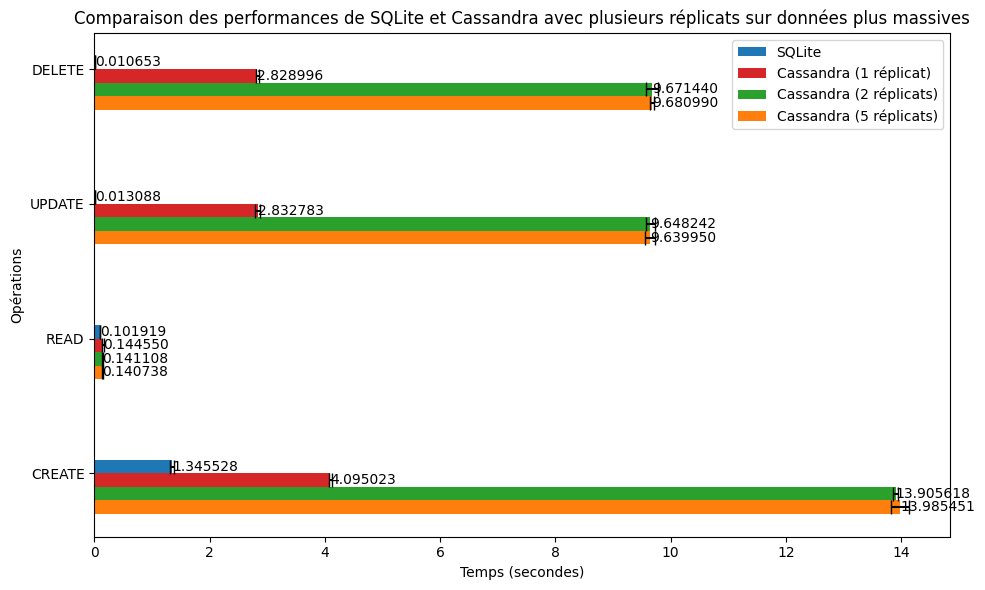

In [ ]:
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean_time, create_sqlite_massive_std_time),
    'READ': (read_sqlite_massive_mean_time, read_sqlite_massive_std_time),
    'UPDATE': (update_sqlite_massive_mean_time, update_sqlite_massive_std_time),
    'DELETE': (delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time)
}

cassandra_times = {
    'CREATE': (create_cas_massive_mean_time, create_cas_massive_std_time),
    'READ': (read_cas_massive_mean_time, read_cas_massive_std_time),
    'UPDATE': (update_cas_massive_mean_time, update_cas_massive_std_time),
    'DELETE': (delete_cas_massive_mean_time, delete_cas_massive_std_time)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2),
    'READ': (read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2),
    'UPDATE': (update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2),
    'DELETE': (delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2)
}

cassandra_times_5 = {
    'CREATE': (create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5),
    'READ': (read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5),
    'UPDATE': (update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5),
    'DELETE': (delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les temps moyens et écarts-types pour chaque système
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y + 0.5 * height, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5, color='tab:blue')
bars2 = ax.barh(y - 0.5 * height, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5, color='tab:red')
bars3 = ax.barh(y - 1.5 * height, cassandra_means_2, height, xerr=cassandra_stds_2, label='Cassandra (2 réplicats)', capsize=5, color='tab:green')
bars4 = ax.barh(y - 2.5 * height, cassandra_means_5, height, xerr=cassandra_stds_5, label='Cassandra (5 réplicats)', capsize=5, color='tab:orange')

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec plusieurs réplicats sur données plus massives')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)

plt.tight_layout()
plt.show()

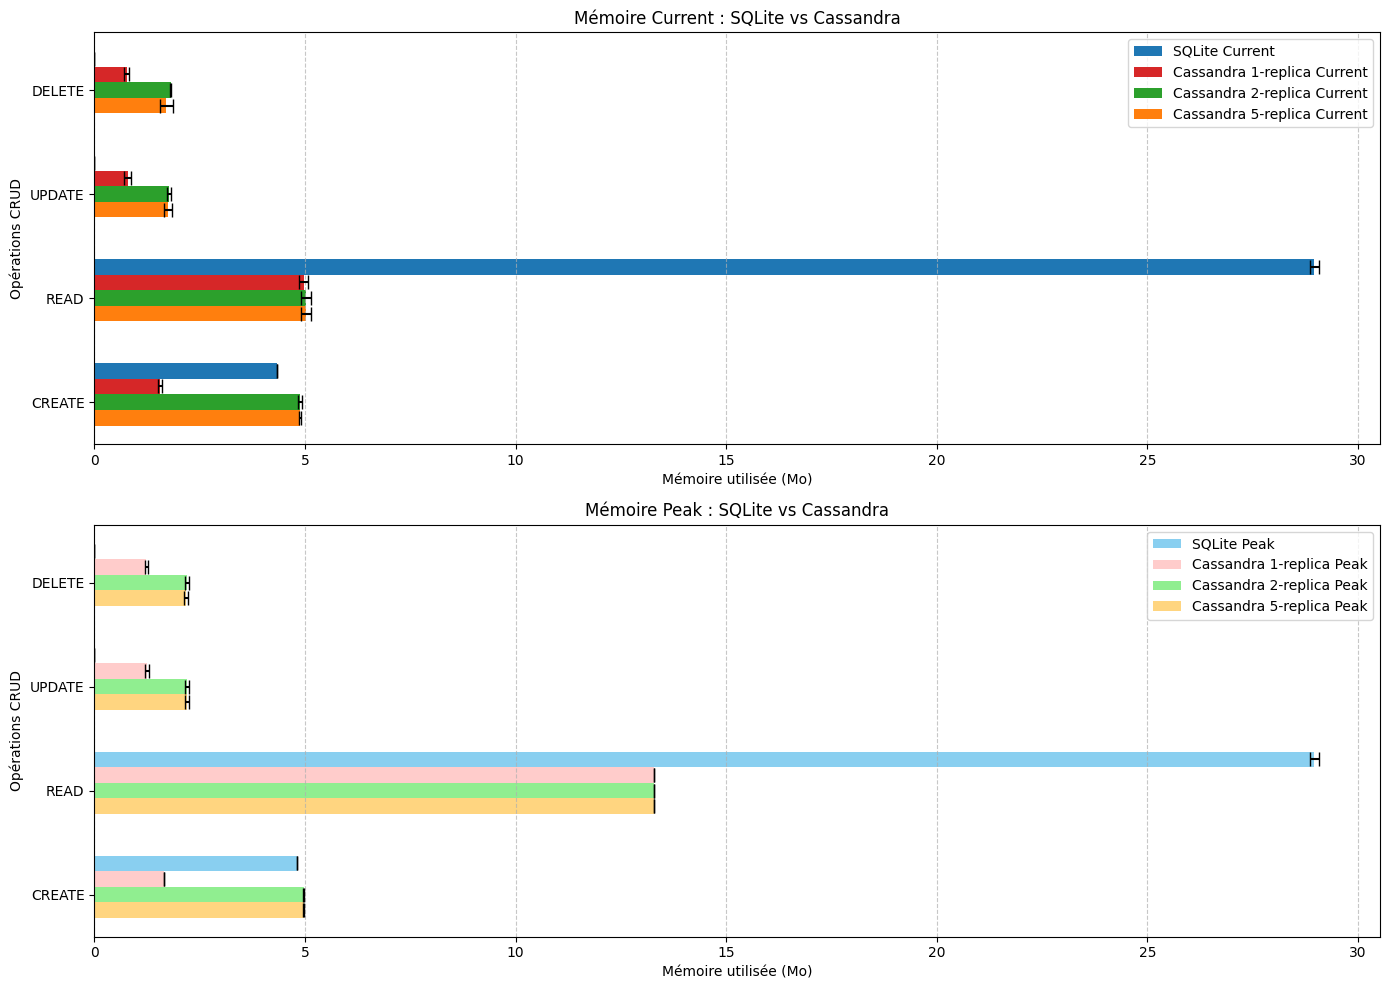

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Valeurs de mémoire pour SQLite
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory),
               'peak': (create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory)},
    'READ': {'current': (read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory),
             'peak': (read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory),
               'peak': (update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory),
               'peak': (delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra avec différentes réplications
cassandra_memory = {
    '1-replica': {
        'CREATE': {'current': (create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory),
                   'peak': (create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory)},
        'READ': {'current': (read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory),
                 'peak': (read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory)},
        'UPDATE': {'current': (update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory),
                   'peak': (update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory)},
        'DELETE': {'current': (delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory),
                   'peak': (delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory)}
    },
    '2-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2),
                   'peak': (create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2),
                 'peak': (read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2),
                   'peak': (update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2),
                   'peak': (delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2)}
    },
    '5-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5),
                   'peak': (create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5),
                 'peak': (read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5),
                   'peak': (update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5),
                   'peak': (delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5)}
    }
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Préparation des données
sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = {replica: [cassandra_memory[replica][op]['current'][0] for op in operations] for replica in cassandra_memory}
cassandra_current_stds = {replica: [cassandra_memory[replica][op]['current'][1] for op in operations] for replica in cassandra_memory}
cassandra_peak_means = {replica: [cassandra_memory[replica][op]['peak'][0] for op in operations] for replica in cassandra_memory}
cassandra_peak_stds = {replica: [cassandra_memory[replica][op]['peak'][1] for op in operations] for replica in cassandra_memory}

y = np.arange(len(operations))
height = 0.15

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

colors = ['tab:red', 'tab:green', 'tab:orange']
# Current Memory
ax[0].barh(y + 2 * height, sqlite_current_means, height, xerr=sqlite_current_stds, label='SQLite Current', color='tab:blue', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[0].barh(y + (1 - i) * height, cassandra_current_means[replica], height, xerr=cassandra_current_stds[replica], 
               label=f'Cassandra {replica} Current', capsize=5, color=colors[i])


colors = ['#FFCCCB', '#90EE90', '#FFD580']
# Peak Memory
ax[1].barh(y + 2 * height, sqlite_peak_means, height, xerr=sqlite_peak_stds, label='SQLite Peak', color='#89CFF0', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[1].barh(y + (1 - i) * height, cassandra_peak_means[replica], height, xerr=cassandra_peak_stds[replica], 
               label=f'Cassandra {replica} Peak', capsize=5, color=colors[i])

# Ajustements graphiques
for i in range(2):
    ax[i].set_xlabel('Mémoire utilisée (Mo)')
    ax[i].set_ylabel('Opérations CRUD')
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(operations)
    ax[i].legend()
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

ax[0].set_title('Mémoire Current : SQLite vs Cassandra')
ax[1].set_title('Mémoire Peak : SQLite vs Cassandra')

plt.tight_layout()
plt.show()


TODO commenter la visualisation aussi 

On voit bien que 1 replica Set bien plus rapide que plus : y a déjà un commentaire là dessus en haut

# Comparaison avec / sans index

### Index secondaires (clés secondaires)


Dans Cassandra, la commande `CREATE INDEX` permet de créer des index secondaires, qui ne sont pas des clés primaires. Cela permet de filtrer les données sur des colonnes autres que la partition key ou les clustering keys.

#### Avantages des index secondaires

- Facilite les filtres sur des colonnes non clés : Vous pouvez filtrer sur des colonnes autres que la partition key ou les clustering keys, ce qui rend les requêtes plus flexibles.
- Accès plus rapide aux données : Les index secondaires optimisent les requêtes qui filtrent sur certaines colonnes spécifiques, réduisant le nombre de partitions à examiner.

#### Inconvénients des index secondaires

- Risque de surcharge de performance : Sur de grandes tables, si une colonne contient beaucoup de valeurs distinctes, l'index peut devenir lourd et ralentir les performances des écritures et lectures.
- Structure distribuée moins efficace : Les index secondaires sont distribués, mais leur gestion est moins performante que les clés primaires, surtout sur des colonnes avec une haute cardinalité.
- Limitations d'usage : Les index secondaires sont mieux utilisés sur des colonnes avec faible cardinalité. Il est déconseillé de les utiliser pour des colonnes ayant une forte cardinalité ou pour des filtres complexes impliquant plusieurs colonnes.
- `ALLOW FILTERING` : Parfois, pour exécuter une requête avec un index secondaire, vous devrez utiliser `ALLOW FILTERING`, ce qui peut nuire aux performances en scannant une grande partie des données.

In [32]:
def cassandra_create_indexes(columns):
    tracemalloc.start()
    start_time = time.time()
    for column in columns:
        index_query = f"CREATE INDEX {column}_idx ON shows ({column});"
        session.execute(index_query)
    cassandra_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    return cassandra_time, current, peak


def sqlite_create_indexes(columns):
    # drop les index
    for column in columns:
        index_query = f"DROP INDEX IF EXISTS {column}_idx;"
        cursor.execute(index_query)

    tracemalloc.start()
    start_time = time.time()
    for column in columns:
        # Créer une requête SQL pour chaque colonne
        index_query = f"CREATE INDEX IF NOT EXISTS {column}_idx ON shows ({column});"
        cursor.execute(index_query)
    sqlite_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    return sqlite_time, current, peak

columns_to_index = ["release_year"]
cassandra_time_index, cassandra_current_index, cassandra_peak_index = cassandra_create_indexes(columns_to_index)
sqlite_time_index, sqlite_current_index, sqlite_peak_index = sqlite_create_indexes(columns_to_index)

print(f"Indexation time: Cassandra {cassandra_time_index:.5f}s, SQLite {sqlite_time_index:.5f}s")
print(f"Current memory: Cassandra {cassandra_current_index:.5f}Mo, SQLite {sqlite_current_index:.5f}Mo")

Indexation time: Cassandra 0.15462s, SQLite 0.00422s
Current memory: Cassandra 0.03792Mo, SQLite 0.00031Mo


In [27]:
# Fonctions pour CRUD SQLite avec index

# --- CREATE ---
def sqlite_insert_index(df):
    drop_table_sqlite()
    create_table_sqlite()
    sqlite_create_indexes(columns_to_index)

    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return create_time_sqlite, current, peak

# --- READ ---
def sqlite_read_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year = 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time_sqlite, current, peak

# --- UPDATE ---
def sqlite_update_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year = 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time_sqlite, current, peak

# --- DELETE ---
def sqlite_delete_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year = 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time_sqlite, current, peak

In [49]:
# Fonctions pour CRUD Cassandra avec index
# --- CREATE ---
def cassandra_insert_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)
    cassandra_create_indexes(columns_to_index)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Create Time: {create_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")

    return create_time, current, peak


# --- READ ---
def cassandra_read_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    result = session.execute('SELECT * FROM shows WHERE release_year = 2000 ;') # ici pas de allow filtering !
    read_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read time with index: {read_time:.5f}s")
    num_records = sum(1 for _ in result)
    print(f"Number of records: {num_records}")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time, current, peak

# Dans Cassandra, pour effectuer un UPDATE, il est nécessaire de spécifier la clé primaire complète (partition key + clustering key).
# Par conséquent, il n'est pas possible de mettre à jour des lignes en fonction de critères de recherche arbitraires, sauf si ces critères correspondent exactement à la clé primaire.

# --- UPDATE ---
def cassandra_update_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    select_query = "SELECT show_id FROM shows WHERE release_year = 2000;"
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]
    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)
    update_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update time with index: {update_time:.5f}s")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time, current, peak


# --- DELETE ---
def cassandra_delete_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    select_query = "SELECT show_id FROM shows WHERE release_year = 2000;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]
    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)
    delete_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete time with index: {delete_time:.5f}s")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time, current, peak

In [ ]:
# sqlite 
# --- CREATE ---
create_sqlite_massive_mean_time_index, create_sqlite_massive_std_time_index, \
    create_sqlite_massive_mean_current_memory_index, create_sqlite_massive_std_current_memory_index, \
        create_sqlite_massive_mean_peak_memory_index, create_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_insert_index, large_df)

# --- READ ---
read_sqlite_massive_mean_time_index, read_sqlite_massive_std_time_index, \
    read_sqlite_massive_mean_current_memory_index, read_sqlite_massive_std_current_memory_index, \
        read_sqlite_massive_mean_peak_memory_index, read_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_read_index, large_df)

# --- UPDATE ---
update_sqlite_massive_mean_time_index, update_sqlite_massive_std_time_index, \
    update_sqlite_massive_mean_current_memory_index, update_sqlite_massive_std_current_memory_index, \
        update_sqlite_massive_mean_peak_memory_index, update_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_update_index, large_df)

# --- DELETE ---
delete_sqlite_massive_mean_time_index, delete_sqlite_massive_std_time_index, \
    delete_sqlite_massive_mean_current_memory_index, delete_sqlite_massive_std_current_memory_index, \
        delete_sqlite_massive_mean_peak_memory_index, delete_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_delete_index, large_df)

Create Time: 1.379541 seconds
Current memory usage is 4.406397819519043Mo; Peak was 4.80125617980957Mo
Create Time: 1.325729 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.352556 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.319780 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.312529 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Total rows in 'shows' table: 30000
Create Time: 1.365878 seconds
Current memory usage is 4.34409236907959Mo; Peak was 4.80078125Mo
Read Time: 0.114080 seconds
Queried 28138 records
Current memory usage is 29.176016807556152Mo; Peak was 29.176016807556152Mo
Create Time: 1.334341 seconds
Current memory usage is 4.343794822692871Mo; Peak was 4.800727844238281Mo
Read Time: 0.113137 seconds
Queried 28138 records
Current memory usage is 28.915350914001465Mo; Peak was 28.915350914001465Mo
Create Time: 1.350944 

In [50]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cassandra_mean_time_index, create_cassandra_std_time_index, \
    create_cassandra_mean_current_memory_index, create_cassandra_std_current_memory_index, \
        create_cassandra_mean_peak_memory_index, create_cassandra_std_peak_memory_index = benchmark_operation(cassandra_insert_index, large_df, 1)

# --- READ ---
read_cassandra_mean_time_index, read_cassandra_std_time_index, \
    read_cassandra_mean_current_memory_index, read_cassandra_std_current_memory_index, \
        read_cassandra_mean_peak_memory_index, read_cassandra_std_peak_memory_index = benchmark_operation(cassandra_read_index, large_df, 1)

# --- UPDATE ---
update_cassandra_mean_time_index, update_cassandra_std_time_index, \
    update_cassandra_mean_current_memory_index, update_cassandra_std_current_memory_index, \
        update_cassandra_mean_peak_memory_index, update_cassandra_std_peak_memory_index = benchmark_operation(cassandra_update_index, large_df, 1)

# --- DELETE ---
delete_cassandra_mean_time_index, delete_cassandra_std_time_index, \
    delete_cassandra_mean_current_memory_index, delete_cassandra_std_current_memory_index, \
        delete_cassandra_mean_peak_memory_index, delete_cassandra_std_peak_memory_index = benchmark_operation(cassandra_delete_index, large_df, 1)

replication factor = 1
Create Time: 14.387584 seconds
Current memory usage is 4.912548065185547Mo; Peak was 4.988912582397461Mo
Update time with index: 0.05025s
Current memory usage is 0.11755943298339844Mo; Peak was 0.16983699798583984Mo
replication factor = 1
Create Time: 14.610397 seconds
Current memory usage is 4.84637451171875Mo; Peak was 4.989604949951172Mo
Update time with index: 0.06212s
Current memory usage is 0.16398906707763672Mo; Peak was 0.16881370544433594Mo
replication factor = 1
Create Time: 14.840947 seconds
Current memory usage is 4.898970603942871Mo; Peak was 4.992091178894043Mo
Update time with index: 0.05242s
Current memory usage is 0.09444141387939453Mo; Peak was 0.1721057891845703Mo
replication factor = 1
Create Time: 15.487996 seconds
Current memory usage is 4.9548845291137695Mo; Peak was 4.980734825134277Mo
Update time with index: 0.06835s
Current memory usage is 0.12530231475830078Mo; Peak was 0.1673421859741211Mo
replication factor = 1
Create Time: 14.664688 

In [99]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_2_index, create_cassandra_massive_std_time_2_index, \
    create_cassandra_massive_mean_current_memory_2_index, create_cassandra_massive_std_current_memory_2_index, \
        create_cassandra_massive_mean_peak_memory_2_index, create_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_insert_index, large_df, 2)

# --- READ ---
read_cassandra_massive_mean_time_2_index, read_cassandra_massive_std_time_2_index, \
    read_cassandra_massive_mean_current_memory_2_index, read_cassandra_massive_std_current_memory_2_index, \
        read_cassandra_massive_mean_peak_memory_2_index, read_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_read_index, large_df, 2)

# --- UPDATE ---
update_cassandra_massive_mean_time_2_index, update_cassandra_massive_std_time_2_index, \
    update_cassandra_massive_mean_current_memory_2_index, update_cassandra_massive_std_current_memory_2_index, \
        update_cassandra_massive_mean_peak_memory_2_index, update_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_update_index, large_df, 2)

# --- DELETE ---
delete_cassandra_massive_mean_time_2_index, delete_cassandra_massive_std_time_2_index, \
    delete_cassandra_massive_mean_current_memory_2_index, delete_cassandra_massive_std_current_memory_2_index, \
        delete_cassandra_massive_mean_peak_memory_2_index, delete_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_delete_index, large_df, 2)


replication factor = 2
Create Time: 13.953807 seconds
Current memory usage is 4.802526473999023Mo; Peak was 4.975226402282715Mo
replication factor = 2
Create Time: 14.051162 seconds
Current memory usage is 4.862112998962402Mo; Peak was 4.969420433044434Mo
replication factor = 2
Create Time: 14.040522 seconds
Current memory usage is 4.907495498657227Mo; Peak was 4.981454849243164Mo
replication factor = 2
Create Time: 13.854619 seconds
Current memory usage is 4.829490661621094Mo; Peak was 4.998378753662109Mo
replication factor = 2
Create Time: 14.105071 seconds
Current memory usage is 4.861557960510254Mo; Peak was 4.976348876953125Mo
replication factor = 2
Create Time: 14.144863 seconds
Current memory usage is 4.8982391357421875Mo; Peak was 4.9766130447387695Mo
Read time with index: 0.13899s
Number of records: 28138
Current memory usage is 5.178070068359375Mo; Peak was 13.286824226379395Mo
replication factor = 2
Create Time: 14.259459 seconds
Current memory usage is 4.9624223709106445Mo;

In [100]:
# 5 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_5_index, create_cassandra_massive_std_time_5_index, \
    create_cassandra_massive_mean_current_memory_5_index, create_cassandra_massive_std_current_memory_5_index, \
        create_cassandra_massive_mean_peak_memory_5_index, create_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_insert_index, large_df, 5)

# --- READ ---
read_cassandra_massive_mean_time_5_index, read_cassandra_massive_std_time_5_index, \
    read_cassandra_massive_mean_current_memory_5_index, read_cassandra_massive_std_current_memory_5_index, \
        read_cassandra_massive_mean_peak_memory_5_index, read_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_read_index, large_df, 5)

# --- UPDATE ---
update_cassandra_massive_mean_time_5_index, update_cassandra_massive_std_time_5_index, \
    update_cassandra_massive_mean_current_memory_5_index, update_cassandra_massive_std_current_memory_5_index, \
        update_cassandra_massive_mean_peak_memory_5_index, update_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_update_index, large_df, 5)

# --- DELETE ---
delete_cassandra_massive_mean_time_5_index, delete_cassandra_massive_std_time_5_index, \
    delete_cassandra_massive_mean_current_memory_5_index, delete_cassandra_massive_std_current_memory_5_index, \
        delete_cassandra_massive_mean_peak_memory_5_index, delete_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_delete_index, large_df, 5)

replication factor = 5
Create Time: 14.022455 seconds
Current memory usage is 4.856956481933594Mo; Peak was 4.9896345138549805Mo
replication factor = 5
Create Time: 14.013805 seconds
Current memory usage is 4.866599082946777Mo; Peak was 4.971941947937012Mo
replication factor = 5
Create Time: 14.342917 seconds
Current memory usage is 4.897610664367676Mo; Peak was 4.988210678100586Mo
replication factor = 5
Create Time: 14.240340 seconds
Current memory usage is 4.820855140686035Mo; Peak was 4.972836494445801Mo
replication factor = 5
Create Time: 14.032453 seconds
Current memory usage is 4.8726301193237305Mo; Peak was 4.973336219787598Mo
replication factor = 5
Create Time: 14.143208 seconds
Current memory usage is 4.946874618530273Mo; Peak was 4.994137763977051Mo
Read time with index: 0.14273s
Number of records: 28138
Current memory usage is 5.178367614746094Mo; Peak was 13.288304328918457Mo
replication factor = 5
Create Time: 14.139729 seconds
Current memory usage is 4.930739402770996Mo; 

### Visualisation

##### Comparaison des temps avec et sans index

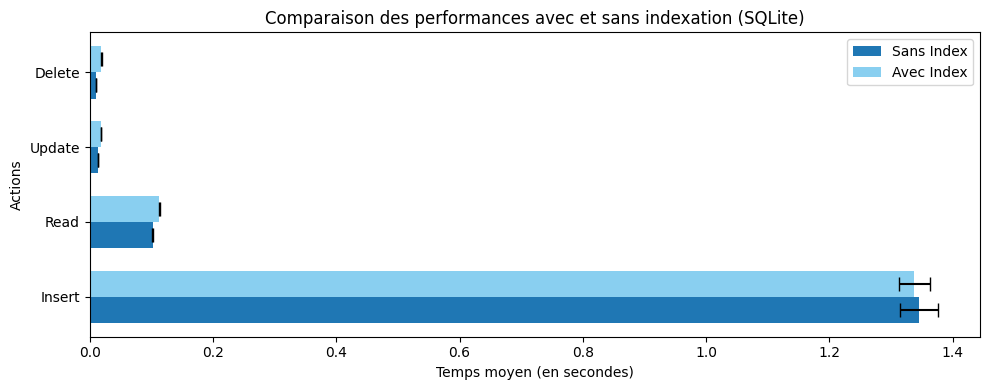

In [139]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_sqlite_massive_mean_time, read_sqlite_massive_mean_time, 
                      update_sqlite_massive_mean_time, delete_sqlite_massive_mean_time]
mean_with_index = [create_sqlite_massive_mean_time_index, read_sqlite_massive_mean_time_index, 
                   update_sqlite_massive_mean_time_index, delete_sqlite_massive_mean_time_index]

std_without_index = [create_sqlite_massive_std_time, read_sqlite_massive_std_time, 
                     update_sqlite_massive_std_time, delete_sqlite_massive_std_time]
std_with_index = [create_sqlite_massive_std_time_index, read_sqlite_massive_std_time_index, 
                  update_sqlite_massive_std_time_index, delete_sqlite_massive_std_time_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 4))

bars1 = ax.barh(x - width/2, mean_without_index, height=width, xerr=std_without_index, label='Sans Index', capsize=5, color='tab:blue')
bars2 = ax.barh(x + width/2, mean_with_index, height=width, xerr=std_with_index, label='Avec Index', capsize=5, color='#89CFF0')

ax.set_ylabel('Actions')
ax.set_xlabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (SQLite)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


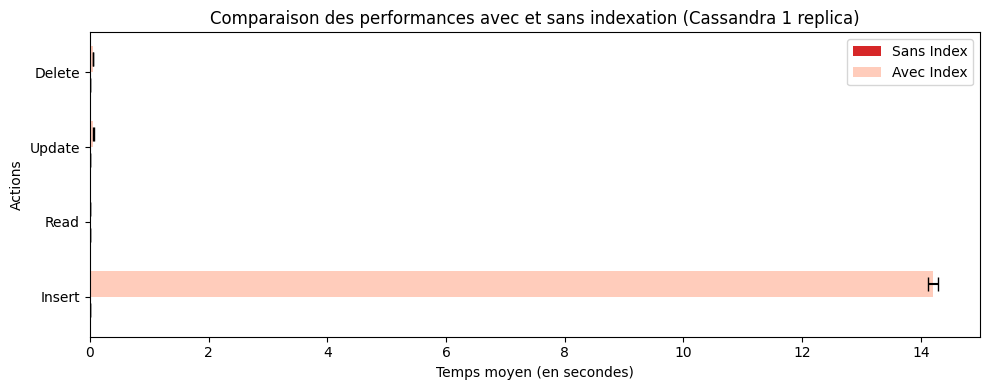

In [51]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cas_mean_time, read_cas_mean_time, 
                      update_cas_mean_time, delete_cas_mean_time]
mean_with_index = [create_cassandra_mean_time_index, read_cassandra_mean_time_index, 
                   update_cassandra_mean_time_index, delete_cassandra_mean_time_index]

std_without_index = [create_cas_std_time, read_cas_std_time, 
                     update_cas_std_time, delete_cas_std_time]
std_with_index = [create_cassandra_std_time_index, read_cassandra_std_time_index, 
                  update_cassandra_std_time_index, delete_cassandra_std_time_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 4))

bars1 = ax.barh(x - width/2, mean_without_index, height=width, xerr=std_without_index, label='Sans Index', capsize=5,color='tab:red')
bars2 = ax.barh(x + width/2, mean_with_index, height=width, xerr=std_with_index, label='Avec Index', capsize=5, color='#FFCCBB')

ax.set_ylabel('Actions')
ax.set_xlabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (Cassandra 1 replica)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


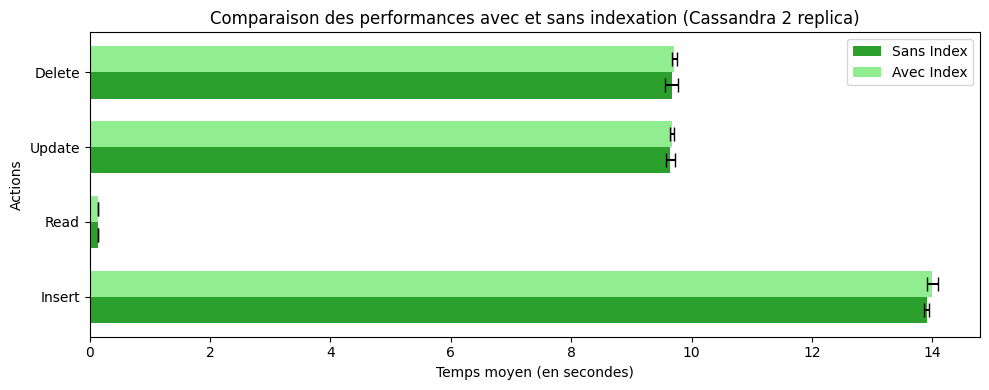

In [141]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_massive_mean_time_2, read_cassandra_massive_mean_time_2, 
                      update_cassandra_massive_mean_time_2, delete_cassandra_massive_mean_time_2]
mean_with_index = [create_cassandra_massive_mean_time_2_index, read_cassandra_massive_mean_time_2_index, 
                   update_cassandra_massive_mean_time_2_index, delete_cassandra_massive_mean_time_2_index]

std_without_index = [create_cassandra_massive_std_time_2, read_cassandra_massive_std_time_2, 
                     update_cassandra_massive_std_time_2, delete_cassandra_massive_std_time_2]
std_with_index = [create_cassandra_massive_std_time_2_index, read_cassandra_massive_std_time_2_index, 
                  update_cassandra_massive_std_time_2_index, delete_cassandra_massive_std_time_2_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 4))

bars1 = ax.barh(x - width/2, mean_without_index, height=width, xerr=std_without_index, label='Sans Index', capsize=5, color='tab:green')
bars2 = ax.barh(x + width/2, mean_with_index, height=width, xerr=std_with_index, label='Avec Index', capsize=5, color='#90EE90')

ax.set_ylabel('Actions')
ax.set_xlabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (Cassandra 2 replica)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


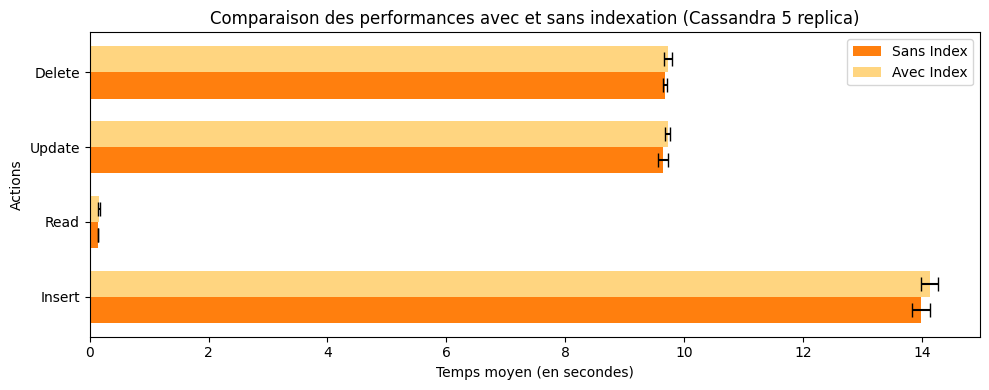

In [142]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_massive_mean_time_5, read_cassandra_massive_mean_time_5, 
                      update_cassandra_massive_mean_time_5, delete_cassandra_massive_mean_time_5]
mean_with_index = [create_cassandra_massive_mean_time_5_index, read_cassandra_massive_mean_time_5_index, 
                   update_cassandra_massive_mean_time_5_index, delete_cassandra_massive_mean_time_5_index]


std_without_index = [create_cassandra_massive_std_time_5, read_cassandra_massive_std_time_5, 
                     update_cassandra_massive_std_time_5, delete_cassandra_massive_std_time_5]
std_with_index = [create_cassandra_massive_std_time_5_index, read_cassandra_massive_std_time_5_index, 
                  update_cassandra_massive_std_time_5_index, delete_cassandra_massive_std_time_5_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 4))

bars1 = ax.barh(x - width/2, mean_without_index, height=width, xerr=std_without_index, label='Sans Index', capsize=5, color='tab:orange')
bars2 = ax.barh(x + width/2, mean_with_index, height=width, xerr=std_with_index, label='Avec Index', capsize=5, color='#FFD580')

ax.set_ylabel('Actions')
ax.set_xlabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (Cassandra 5 replica)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


##### Comparaison de la mémoire avec et sans les index

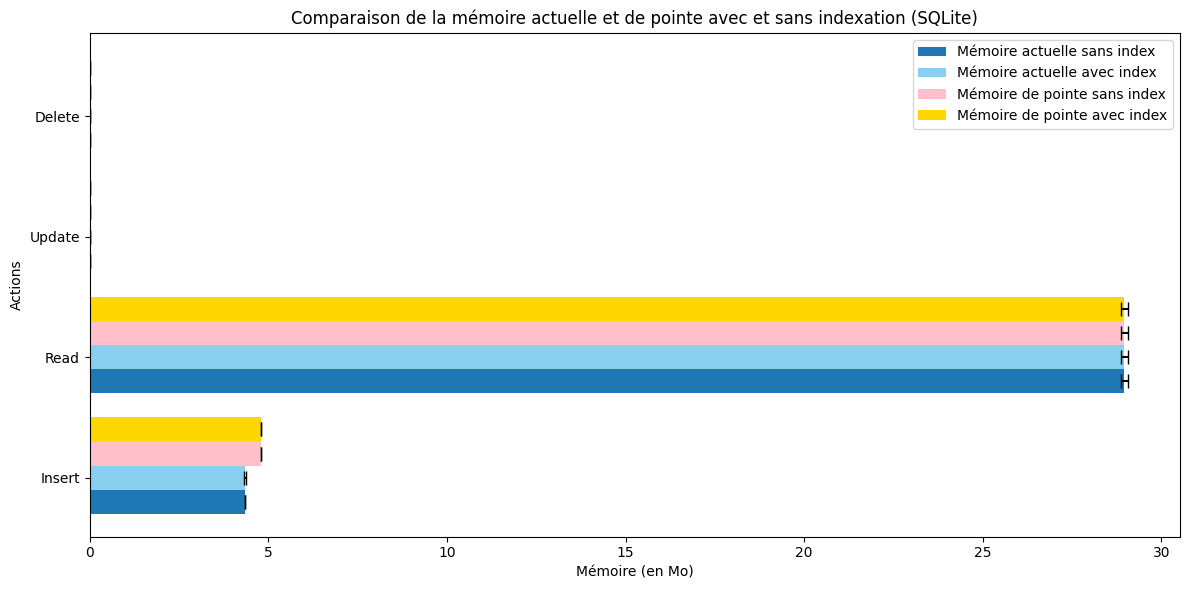

In [143]:
import matplotlib.pyplot as plt
import numpy as np

actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_sqlite_massive_mean_current_memory, read_sqlite_massive_mean_current_memory, 
                              update_sqlite_massive_mean_current_memory, delete_sqlite_massive_mean_current_memory]
mean_current_with_index = [create_sqlite_massive_mean_current_memory_index, read_sqlite_massive_mean_current_memory_index, 
                           update_sqlite_massive_mean_current_memory_index, delete_sqlite_massive_mean_current_memory_index]
std_current_without_index = [create_sqlite_massive_std_current_memory, read_sqlite_massive_std_current_memory, 
                             update_sqlite_massive_std_current_memory, delete_sqlite_massive_std_current_memory]
std_current_with_index = [create_sqlite_massive_std_current_memory_index, read_sqlite_massive_std_current_memory_index, 
                          update_sqlite_massive_std_current_memory_index, delete_sqlite_massive_std_current_memory_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_sqlite_massive_mean_peak_memory, read_sqlite_massive_mean_peak_memory, 
                           update_sqlite_massive_mean_peak_memory, delete_sqlite_massive_mean_peak_memory]
mean_peak_with_index = [create_sqlite_massive_mean_peak_memory_index, read_sqlite_massive_mean_peak_memory_index, 
                        update_sqlite_massive_mean_peak_memory_index, delete_sqlite_massive_mean_peak_memory_index]
std_peak_without_index = [create_sqlite_massive_std_peak_memory, read_sqlite_massive_std_peak_memory, 
                          update_sqlite_massive_std_peak_memory, delete_sqlite_massive_std_peak_memory]
std_peak_with_index = [create_sqlite_massive_std_peak_memory_index, read_sqlite_massive_std_peak_memory_index, 
                       update_sqlite_massive_std_peak_memory_index, delete_sqlite_massive_std_peak_memory_index]

x = np.arange(len(actions))
width = 0.2  # Réduire la largeur pour accueillir plus de barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres pour la mémoire actuelle
bars_current_without = ax.barh(x - width, mean_current_without_index, height=width, xerr=std_current_without_index, 
                               label='Mémoire actuelle sans index', capsize=5, color='tab:blue')
bars_current_with = ax.barh(x, mean_current_with_index, height=width, xerr=std_current_with_index, 
                            label='Mémoire actuelle avec index', capsize=5, color='#89CFF0')

# Barres pour la mémoire de pointe
bars_peak_without = ax.barh(x + width, mean_peak_without_index, height=width, xerr=std_peak_without_index, 
                            label='Mémoire de pointe sans index', capsize=5, color='pink')
bars_peak_with = ax.barh(x + 2 * width, mean_peak_with_index, height=width, xerr=std_peak_with_index, 
                         label='Mémoire de pointe avec index', capsize=5, color='gold')

# Ajustements des axes et légende
ax.set_ylabel('Actions')
ax.set_xlabel('Mémoire (en Mo)')
ax.set_title('Comparaison de la mémoire actuelle et de pointe avec et sans indexation (SQLite)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


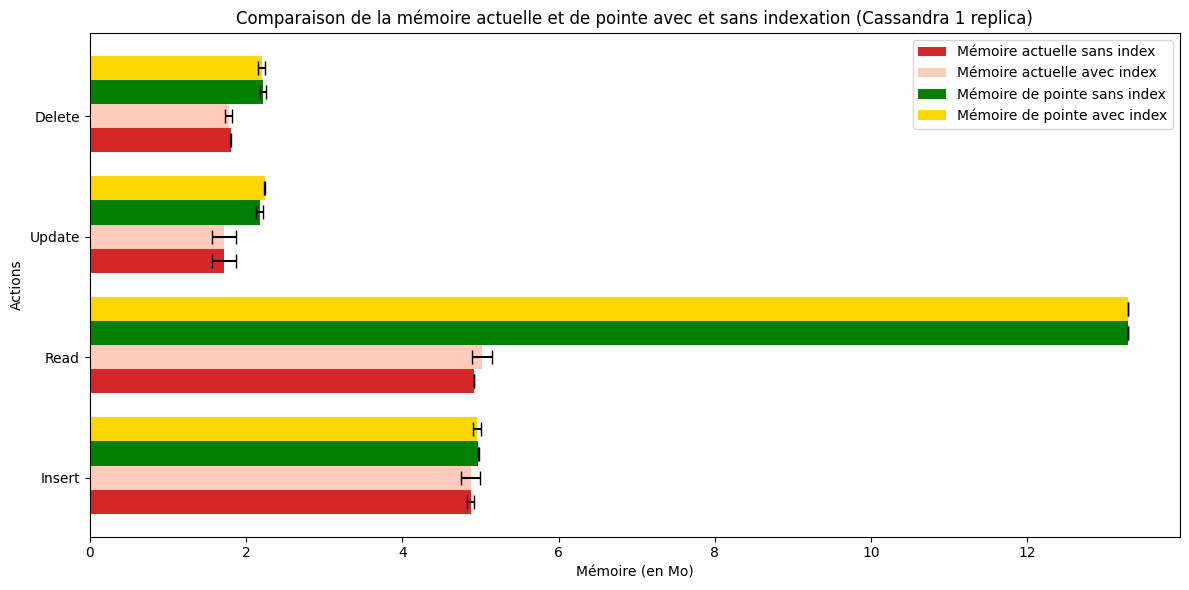

In [146]:
import matplotlib.pyplot as plt
import numpy as np

actions = ['Insert', 'Read', 'Update', 'Delete']


# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_cas_mean_current_memory, read_cas_mean_current_memory, 
                              update_cas_mean_current_memory, delete_cas_mean_current_memory]
mean_current_with_index = [create_cassandra_mean_current_memory_index, read_cassandra_mean_current_memory_index, 
                           update_cassandra_mean_current_memory_index, delete_cassandra_mean_current_memory_index]
std_current_without_index = [create_cas_std_current_memory, read_cas_std_current_memory, 
                             update_cas_std_current_memory, delete_cas_std_current_memory]
std_current_with_index = [create_cassandra_std_current_memory_index, read_cassandra_std_current_memory_index, 
                          update_cassandra_std_current_memory_index, delete_cassandra_std_current_memory_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_cas_mean_peak_memory, read_cas_mean_peak_memory, 
                           update_cas_mean_peak_memory, delete_cas_mean_peak_memory]
mean_peak_with_index = [create_cassandra_mean_peak_memory_index, read_cassandra_mean_peak_memory_index, 
                        update_cassandra_mean_peak_memory_index, delete_cassandra_mean_peak_memory_index]
std_peak_without_index = [create_cas_std_peak_memory, read_cas_std_peak_memory, 
                          update_cas_std_peak_memory, delete_cas_std_peak_memory]
std_peak_with_index = [create_cassandra_std_peak_memory_index, read_cassandra_std_peak_memory_index, 
                       update_cassandra_std_peak_memory_index, delete_cassandra_std_peak_memory_index]

x = np.arange(len(actions))
width = 0.2  # Réduire la largeur pour accueillir plus de barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres pour la mémoire actuelle
bars_current_without = ax.barh(x - width, mean_current_without_index, height=width, xerr=std_current_without_index, 
                               label='Mémoire actuelle sans index', capsize=5, color='tab:red')
bars_current_with = ax.barh(x, mean_current_with_index, height=width, xerr=std_current_with_index, 
                            label='Mémoire actuelle avec index', capsize=5, color='#FFCCBB')

# Barres pour la mémoire de pointe
bars_peak_without = ax.barh(x + width, mean_peak_without_index, height=width, xerr=std_peak_without_index, 
                            label='Mémoire de pointe sans index', capsize=5, color='green')
bars_peak_with = ax.barh(x + 2 * width, mean_peak_with_index, height=width, xerr=std_peak_with_index, 
                         label='Mémoire de pointe avec index', capsize=5, color='gold')

# Ajustements des axes et légende
ax.set_ylabel('Actions')
ax.set_xlabel('Mémoire (en Mo)')
ax.set_title('Comparaison de la mémoire actuelle et de pointe avec et sans indexation (Cassandra 1 replica)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


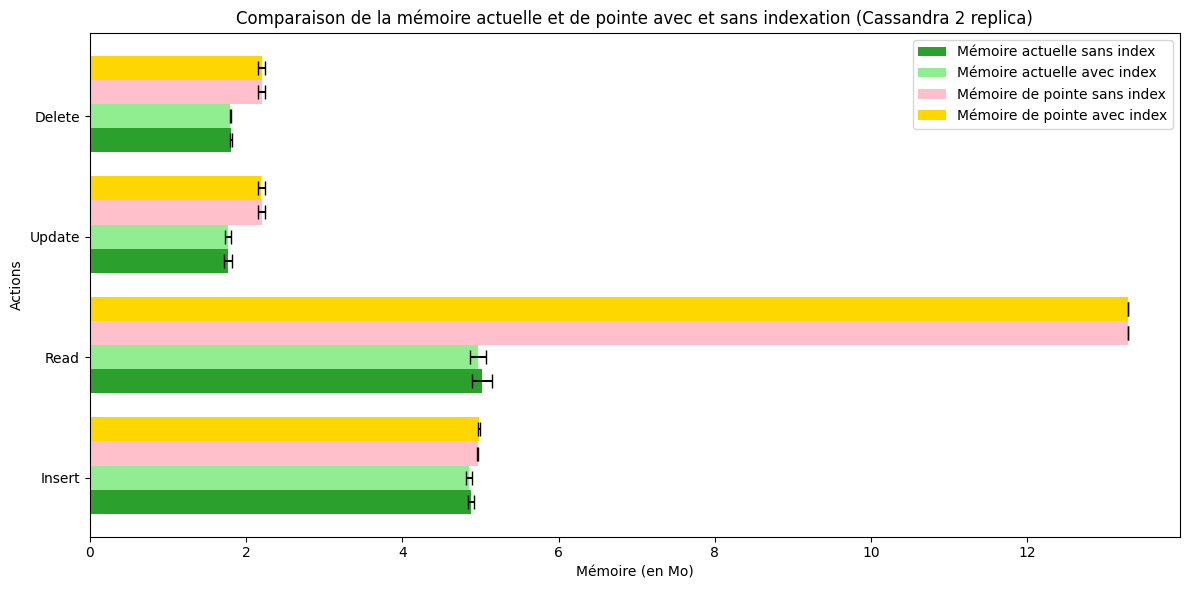

In [148]:
create_cassandra_massive_mean_time_2
update_cassandra_massive_mean_time_5_index

import matplotlib.pyplot as plt
import numpy as np

actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_cassandra_massive_mean_current_memory_2, read_cassandra_massive_mean_current_memory_2, 
                              update_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_mean_current_memory_2]
mean_current_with_index = [create_cassandra_massive_mean_current_memory_2_index, read_cassandra_massive_mean_current_memory_2_index, 
                           update_cassandra_massive_mean_current_memory_2_index, delete_cassandra_massive_mean_current_memory_2_index]
std_current_without_index = [create_cassandra_massive_std_current_memory_2, read_cassandra_massive_std_current_memory_2, 
                             update_cassandra_massive_std_current_memory_2, delete_cassandra_massive_std_current_memory_2]
std_current_with_index = [create_cassandra_massive_std_current_memory_2_index, read_cassandra_massive_std_current_memory_2_index, 
                          update_cassandra_massive_std_current_memory_2_index, delete_cassandra_massive_std_current_memory_2_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_mean_peak_memory_2, 
                           update_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_mean_peak_memory_2]
mean_peak_with_index =  [create_cassandra_massive_mean_peak_memory_2_index, read_cassandra_massive_mean_peak_memory_2_index, 
                           update_cassandra_massive_mean_peak_memory_2_index, delete_cassandra_massive_mean_peak_memory_2_index]
std_peak_without_index = [create_cassandra_massive_std_peak_memory_2, read_cassandra_massive_std_peak_memory_2, 
                          update_cassandra_massive_std_peak_memory_2, delete_cassandra_massive_std_peak_memory_2]
std_peak_with_index = [create_cassandra_massive_std_peak_memory_2_index, read_cassandra_massive_std_peak_memory_2_index, 
                          update_cassandra_massive_std_peak_memory_2_index, delete_cassandra_massive_std_peak_memory_2_index]

x = np.arange(len(actions))
width = 0.2  # Réduire la largeur pour accueillir plus de barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres pour la mémoire actuelle
bars_current_without = ax.barh(x - width, mean_current_without_index, height=width, xerr=std_current_without_index, 
                               label='Mémoire actuelle sans index', capsize=5, color='tab:green')
bars_current_with = ax.barh(x, mean_current_with_index, height=width, xerr=std_current_with_index, 
                            label='Mémoire actuelle avec index', capsize=5, color='#90EE90')

# Barres pour la mémoire de pointe
bars_peak_without = ax.barh(x + width, mean_peak_without_index, height=width, xerr=std_peak_without_index, 
                            label='Mémoire de pointe sans index', capsize=5, color='pink')
bars_peak_with = ax.barh(x + 2 * width, mean_peak_with_index, height=width, xerr=std_peak_with_index, 
                         label='Mémoire de pointe avec index', capsize=5, color='gold')

# Ajustements des axes et légende
ax.set_ylabel('Actions')
ax.set_xlabel('Mémoire (en Mo)')
ax.set_title('Comparaison de la mémoire actuelle et de pointe avec et sans indexation (Cassandra 2 replica)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


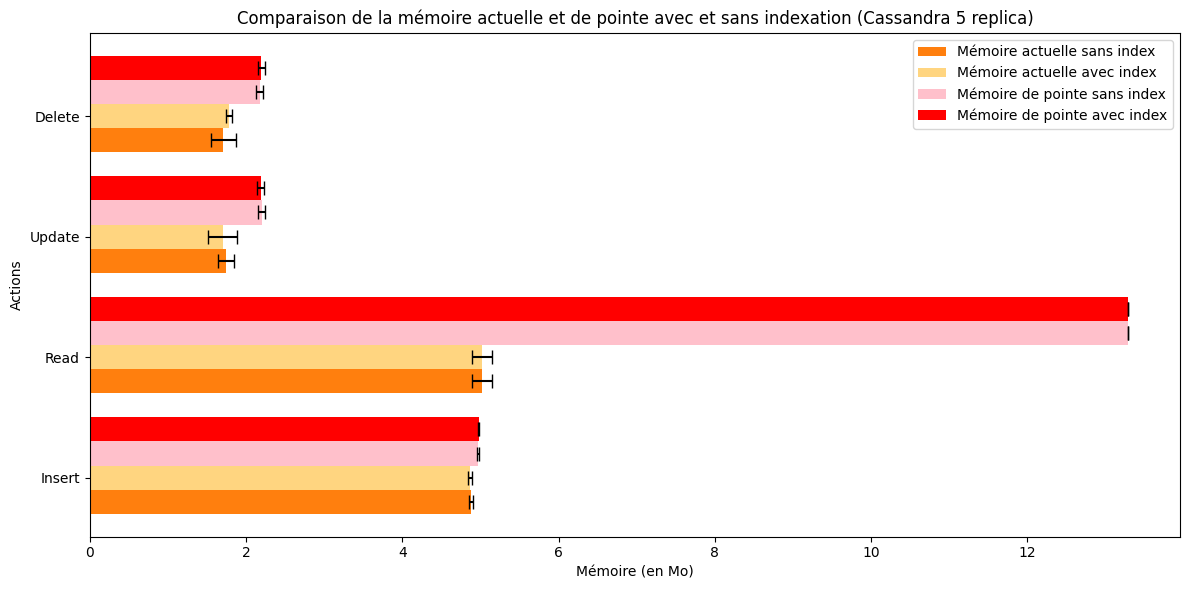

In [152]:
create_cassandra_massive_mean_time_2
update_cassandra_massive_mean_time_5_index

import matplotlib.pyplot as plt
import numpy as np

actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_cassandra_massive_mean_current_memory_5, read_cassandra_massive_mean_current_memory_5, 
                              update_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_mean_current_memory_5]
mean_current_with_index = [create_cassandra_massive_mean_current_memory_5_index, read_cassandra_massive_mean_current_memory_5_index, 
                           update_cassandra_massive_mean_current_memory_5_index, delete_cassandra_massive_mean_current_memory_5_index]
std_current_without_index = [create_cassandra_massive_std_current_memory_5, read_cassandra_massive_std_current_memory_5, 
                             update_cassandra_massive_std_current_memory_5, delete_cassandra_massive_std_current_memory_5]
std_current_with_index = [create_cassandra_massive_std_current_memory_5_index, read_cassandra_massive_std_current_memory_5_index, 
                          update_cassandra_massive_std_current_memory_5_index, delete_cassandra_massive_std_current_memory_5_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_mean_peak_memory_5, 
                           update_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_mean_peak_memory_5]
mean_peak_with_index =  [create_cassandra_massive_mean_peak_memory_5_index, read_cassandra_massive_mean_peak_memory_5_index, 
                           update_cassandra_massive_mean_peak_memory_5_index, delete_cassandra_massive_mean_peak_memory_5_index]
std_peak_without_index = [create_cassandra_massive_std_peak_memory_5, read_cassandra_massive_std_peak_memory_5, 
                          update_cassandra_massive_std_peak_memory_5, delete_cassandra_massive_std_peak_memory_5]
std_peak_with_index = [create_cassandra_massive_std_peak_memory_5_index, read_cassandra_massive_std_peak_memory_5_index, 
                          update_cassandra_massive_std_peak_memory_5_index, delete_cassandra_massive_std_peak_memory_5_index]

x = np.arange(len(actions))
width = 0.2  # Réduire la largeur pour accueillir plus de barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres pour la mémoire actuelle
bars_current_without = ax.barh(x - width, mean_current_without_index, height=width, xerr=std_current_without_index, 
                               label='Mémoire actuelle sans index', capsize=5, color='tab:orange')
bars_current_with = ax.barh(x, mean_current_with_index, height=width, xerr=std_current_with_index, 
                            label='Mémoire actuelle avec index', capsize=5, color='#FFD580')

# Barres pour la mémoire de pointe
bars_peak_without = ax.barh(x + width, mean_peak_without_index, height=width, xerr=std_peak_without_index, 
                            label='Mémoire de pointe sans index', capsize=5, color='pink')
bars_peak_with = ax.barh(x + 2 * width, mean_peak_with_index, height=width, xerr=std_peak_with_index, 
                         label='Mémoire de pointe avec index', capsize=5, color='red')

# Ajustements des axes et légende
ax.set_ylabel('Actions')
ax.set_xlabel('Mémoire (en Mo)')
ax.set_title('Comparaison de la mémoire actuelle et de pointe avec et sans indexation (Cassandra 5 replica)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


# TODO : il a fallu passer par clef primaire blablabla

Nous avons tenté d'inclure `release_year` dans la clé primaire (partition et clustering) afin d'éviter l'utilisation de `ALLOW FILTERING`. Cependant, cela s'est révélé compliqué à mettre en œuvre dans notre cas. Une alternative aurait été de se limiter à des requêtes utilisant uniquement la clé primaire simple `show_id`, mais cette approche a peu d'utilité pratique dans la réalité.

Ainsi, nous avons conservé la version où `release_year > 2000`, même si cette condition nécessite un parcours partiel des partitions, ce qui n'est pas pris en charge nativement sans `ALLOW FILTERING`.

Une autre option aurait été d'utiliser une vue matérialisée pour optimiser les requêtes sur `release_year`, mais nous avons préféré une approche où nous récupérons d'abord l'identifiant (`show_id`) avant toute opération de mise à jour ou de suppression.

In [107]:
# TODO Charlotte tu veux dire quoi ?
# Tester avec des requêtes plus complexes
# Utiliser un dataset plus grand (ça c'est au dessus)
#  Ajouter des colonnes à indexer (c'est fait aussi au dessus)
# Tous ces TODO n'ont rien changé.

# Fin du notebook

In [108]:
# fermer proprement
session.shutdown() # Fermer la connexion Cassandra
cluster.shutdown() # Fermer le cluster Cassandra
conn.close() # Fermer la connexion SQLite
cursor.close() # Fermer le curseur SQLite

ProgrammingError: Cannot operate on a closed database.

TODO en haut : attention notebook très long à cause du benchmark : beaucoup de cretae, insert à chaque fois sur 30000 données -> lourd 